# Experiment Tracking with MLFlow (Local)

In this demo we will see how to use MLFlow for tracking experiments, using a toy data set. In the attached lab (below), you will download a larger dataset and attempt to train the best model that you can.

We should first install mlflow, and add it to the requirements.txt file if not done already.

`pip install mlflow` or `python3 -m pip install mlflow`.

You may also need to `pip install setuptools`.

From here, make sure to save this notebook in a specific folder, and ensure you run all command line commands from the same folder.

In [1]:
import mlflow
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score

After loading the libraries, we can first check the mlflow version you have. And, just for fun, let's look at the mlflow UI by running `mlflow ui`. After this, we should do two things:
- set the tracking uri
- create or set the experiment

Setting the tracking uri tells mlflow where to save the results of our experiments. We will first save these locally in a sqlite instance. In a future lab we will set up mlflow to run in GCP.

If you've already created an experiment previously that you'd like to use, you can tell mlflow by setting the experiment. You can also use `set_experiment` even if the experiment has not yet been created - mlflow will first check if the experiment exists, and if not, it will create it for you. 

In [2]:
mlflow.__version__

'2.15.1'

Running the below code will create a sqlite database and an mlruns folder in the current directory.

In [3]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('demo-experiment')

2025/03/24 23:30:56 INFO mlflow.tracking.fluent: Experiment with name 'demo-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/samanvitha/mlops/notebooks/mlruns/1', creation_time=1742884256099, experiment_id='1', last_update_time=1742884256099, lifecycle_stage='active', name='demo-experiment', tags={}>

From here, we can load the wine data from sklearn and take a look at it. Then let's play around with some models, without using mlflow for now, to get a sense of why mlflow might come in handy.

In [4]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


In [5]:
y = wine.target
X = df_wine
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X, y)

DecisionTreeClassifier(max_depth=4)

In [6]:
accuracy_score(y, dt.predict(df_wine))

0.9887640449438202

## Train a Model Using MLFLow

In this section, let's train a simple decision tree model, where we will now adjust the maximum depth (`max_depth`) of the tree, and save the results of each run of the experiment using mlflow. To do so, we need to tell mlflow to start recording. We do this with `start_run`. 

The things we might want to record in this simple case are:
- the value of `max_depth`
- the corresponding accuracy of the model

We can also tag each run to make it easier to identify them later.

After running the below code, be sure to check the mlflow UI by running the following in the terminal from the same directory as where you saved this notebook:

`mlflow ui` note that just running this you will not see any of your experiments. You must specify the uri (the place where all of your results are being stored)

`mlflow ui --backend-store-uri sqlite:///mlflow.db`

In [7]:
with mlflow.start_run():
    # log parameters and log metrics
    # parameters: hyperparameters
    # metrics: model performance metrics

    mlflow.set_tags({"Model":"decision-tree", "Train Data": "all-data"})

    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X, y)
    acc = accuracy_score(y, dt.predict(df_wine))

    mlflow.log_param("max_depth", tree_depth)
    mlflow.log_metric("accuracy", acc)

mlflow.end_run()

Let's do it again, but this time we'll use a random forest, which has some other hyperparameters we can tune, which makes keeping track of things a little more complex without a tool like mlflow.

In [8]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run():
    mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

    ntree = 1000
    mtry = 4

    mlflow.log_params({'n_estimators':ntree, 'max_features':mtry})

    rf = RandomForestClassifier(n_estimators = ntree, max_features = mtry, oob_score = True)
    rf.fit(X,y)
    acc = rf.oob_score_
    #acc = accuracy_score(y, rf.predict(X))
    mlflow.log_metric('accuracy', acc)

mlflow.end_run()

Typically, in a real-world scenario, you wouldn't change your parameter values manually and re-run your code, you would either use a loop to loop through different parameter values, or you'd use a built-in method for doing cross-validation, of which there are a few. First, let's use a simple loop to run the experiment multiple times, and save the results of each run.

In [9]:
ntrees = [20,40,60,80,100]
mtrys = [3,4,5]
for i in ntrees:
    for j in mtrys:
        with mlflow.start_run():
            mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

            mlflow.log_params({'n_estimators':i, 'max_features':j})

            rf = RandomForestClassifier(n_estimators = i, max_features = j, oob_score = True)
            rf.fit(X,y)
            acc = rf.oob_score_
            #acc = accuracy_score(y, rf.predict(X))
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

## Training a Model with mlflow and hyperopt

One way of tuning your model is to use the `hyperopt` library. `hyperopt` is a library that does hyperparameter tuning, and does so in a way that makes it easy for mlflow to keep track of the results. 

First, install the libraries you don't have, and then load them below. We do not use `hyperopt` much in the class, so if you don't want to add it to your requirements.txt file, you don't have to.

For this exercise, we'll split the data into training and validation, and then we'll train decision trees and random forests and use `hyperopt` to do the hyperparameter tuning and find the best model for us.

In [10]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

From the above we will use `cross_val_score` for our metric, `fmin` is used by `hyperopt` to do the tuning, `tpe` (Tree of Parzen Estimators) is the algorithm used to search the hyperparameter space,  `hp` has methods we need to use for defining our search space, `STATUS_OK` is a status message that each run completed, and `Trials` keeps track of each run.

In [11]:
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}

search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()

In [12]:
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

100%|██████████| 32/32 [00:18<00:00,  1.72trial/s, best loss: -0.9888888888888889]


In [13]:
best_result

{'classifier_type': 1,
 'criterion': 1,
 'rf_max_features': 2,
 'rf_n_estimators': 83}

### Using Autologging

Rather than manually logging parameters and metrics, mlflow has an autolog feature, which is compatible with a subset of python libraries, such as sklearn. Autologging makes it easy to log all of the important stuff, without having to manually write lines of code to log the parameters. However, sometimes you will want to have finer control over what gets logged, and should instead skip autologging.

In [14]:

with mlflow.start_run():
    mlflow.sklearn.autolog()
    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X_train, y_train)
    mlflow.sklearn.autolog(disable=True)
mlflow.end_run()

# Artifact Tracking and Model Registry (Local)

In this section we will save some artifacts from our model as we go through the model development process. There are a few things that might be worth saving, such as datasets, plots, and the final model itself that might go into production later.

## Data

First, let's see how we can store our important datasets, in a compressed format, for use for later, for example, in case we get a new request about our model and need to run some analyses (such as "what is the distribution of this feature, but only for this specific subset of data?" or "how did the model do on these particular observations from your validation set?").

In [15]:
import os 

os.makedirs('save_data', exist_ok = True)

X_train.to_parquet('save_data/x_train.parquet')

mlflow.log_artifact('save_data/x_train.parquet')

In [16]:
X_test.to_parquet('save_data/x_test.parquet')

mlflow.log_artifacts('save_data/')

You can now go to the mlflow UI, click on the latest run, and select the Artifacts tab. You should see something similar to this:
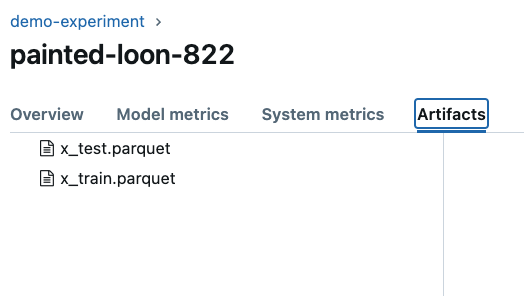

## Images

As part of the model dev process you may end up creating visualizations that can be useful for analysis, or for reporting. You can use mlflow to log the important ones and ignore the rest. After creating the below figure, save into a folder called images, and then you can log whatever is in the `images` folder as an artifact.

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

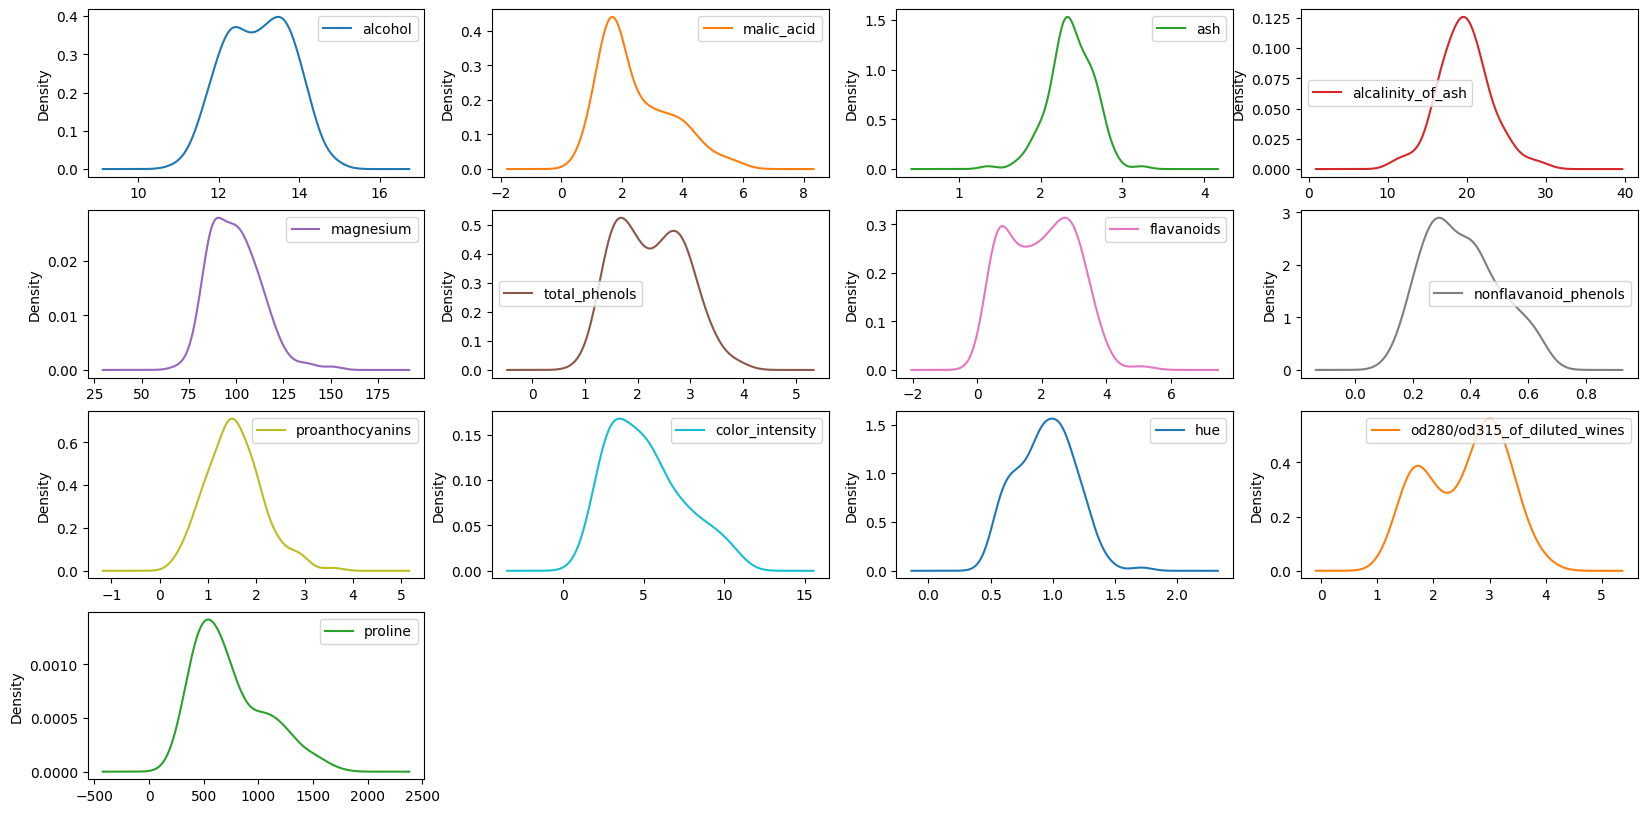

In [17]:
%matplotlib inline
os.makedirs('images', exist_ok = True)
X_train.plot.density(subplots = True, figsize = (20,10), layout = (4,4), sharey = False, sharex = False)

In [18]:
mlflow.log_artifacts('images')
mlflow.end_run()

Notice how all of the artifacts were saved in the same run of the experiment. We could have added an `mlflow.end_run()` in between our `log_artifacts` lines to separate runs if we wanted to.

## Model Management and Model Registry

As you are developing your models you may want to save certain versions of the model, or maybe even all of them, so that you don't have to go back and retrain them later. We can do this in mlflow by logging the models, not as artifacts, but as models, using `log_model`. 

In this section we'll log a couple of models to see how mlflow handles model management. Above, we used `hyperopt` to train a bunch of models at once. Let's do this again, and log some of the models that we train.

### Logging as an Artifact

First we can try logging a model as an artifact. To do this, we must first save the model itself, which we can do by using the `pickle` library. We then log the model as an artifact like we did with data and images. 

In [19]:
import pickle

os.makedirs('../models', exist_ok = True)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

with open('../models/model.pkl','wb') as f:
    pickle.dump(dt,f)

# First we'll log the model as an artifact
mlflow.log_artifact('../models/model.pkl', artifact_path='my_models')

### Logging as a Model

Logging the model as an artifact only logs the pickle file (the serialized version of the model). It's not really very useful, especially since models contain so much metadata that might be critical to know for deploying the model later. mlflow has a built-in way of logging models specifically, so let's see how to use this, and how it's different from logging models as an artifact.

In [20]:
# Let's do it again, but this time we will log the model using log_model
mlflow.sklearn.log_model(dt, artifact_path = 'better_models')
mlflow.end_run()

2025/03/24 23:31:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Ok, so if you go to the mlflow UI at this point you can see the difference in `log_artifact`, which simply logs the pickle file, and `log_model`, which also gives you information about the environment, required packages, and model flavor.

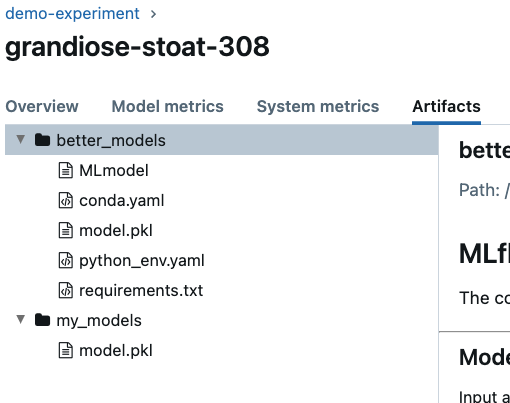

Let's do this one more time, but this time let's use `hyperopt` and log all of the trained models separately. Let's do this in a new experiment called 'demo-experiment2'. 

In [21]:
mlflow.set_experiment('demo-experiment2')
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(clf, artifact_path = 'better_models')
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}
search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

2025/03/24 23:31:30 INFO mlflow.tracking.fluent: Experiment with name 'demo-experiment2' does not exist. Creating a new experiment.


  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/03/24 23:31:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  3%|▎         | 1/32 [00:01<01:00,  1.96s/trial, best loss: -0.8765079365079365]

2025/03/24 23:31:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  6%|▋         | 2/32 [00:05<01:22,  2.75s/trial, best loss: -0.9776190476190475]

2025/03/24 23:31:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  9%|▉         | 3/32 [00:11<02:08,  4.45s/trial, best loss: -0.9777777777777779]

2025/03/24 23:32:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 12%|█▎        | 4/32 [00:38<06:06, 13.10s/trial, best loss: -0.9777777777777779]

2025/03/24 23:32:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 16%|█▌        | 5/32 [00:40<04:11,  9.32s/trial, best loss: -0.9777777777777779]

2025/03/24 23:32:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 19%|█▉        | 6/32 [00:43<03:01,  6.96s/trial, best loss: -0.9777777777777779]

2025/03/24 23:32:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 22%|██▏       | 7/32 [00:52<03:11,  7.65s/trial, best loss: -0.9777777777777779]

2025/03/24 23:32:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 25%|██▌       | 8/32 [00:55<02:34,  6.43s/trial, best loss: -0.9777777777777779]

2025/03/24 23:32:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 28%|██▊       | 9/32 [00:58<02:02,  5.35s/trial, best loss: -0.9777777777777779]

2025/03/24 23:32:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 31%|███▏      | 10/32 [01:01<01:37,  4.44s/trial, best loss: -0.9777777777777779]

2025/03/24 23:32:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 34%|███▍      | 11/32 [01:03<01:19,  3.81s/trial, best loss: -0.9777777777777779]

2025/03/24 23:32:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 38%|███▊      | 12/32 [01:06<01:11,  3.57s/trial, best loss: -0.9833333333333332]

2025/03/24 23:32:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 41%|████      | 13/32 [01:09<01:00,  3.19s/trial, best loss: -0.9833333333333332]

2025/03/24 23:32:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 44%|████▍     | 14/32 [01:11<00:53,  2.97s/trial, best loss: -0.9833333333333332]

2025/03/24 23:32:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 47%|████▋     | 15/32 [01:13<00:47,  2.81s/trial, best loss: -0.9833333333333332]

2025/03/24 23:32:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 16/32 [01:15<00:38,  2.38s/trial, best loss: -0.9833333333333332]

2025/03/24 23:32:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 53%|█████▎    | 17/32 [01:16<00:30,  2.04s/trial, best loss: -0.9833333333333332]

2025/03/24 23:32:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 56%|█████▋    | 18/32 [01:18<00:27,  1.98s/trial, best loss: -0.9833333333333332]

2025/03/24 23:32:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 59%|█████▉    | 19/32 [01:20<00:25,  1.94s/trial, best loss: -0.9833333333333332]

2025/03/24 23:32:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 62%|██████▎   | 20/32 [01:21<00:21,  1.78s/trial, best loss: -0.9833333333333332]

2025/03/24 23:32:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 66%|██████▌   | 21/32 [01:23<00:20,  1.89s/trial, best loss: -0.9833333333333332]

2025/03/24 23:32:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 69%|██████▉   | 22/32 [01:26<00:20,  2.04s/trial, best loss: -0.9833333333333332]

2025/03/24 23:32:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 72%|███████▏  | 23/32 [01:27<00:16,  1.86s/trial, best loss: -0.9888888888888889]

2025/03/24 23:32:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 75%|███████▌  | 24/32 [01:29<00:14,  1.78s/trial, best loss: -0.9888888888888889]

2025/03/24 23:33:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 78%|███████▊  | 25/32 [01:31<00:14,  2.00s/trial, best loss: -0.9888888888888889]

2025/03/24 23:33:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 81%|████████▏ | 26/32 [01:34<00:12,  2.12s/trial, best loss: -0.9888888888888889]

2025/03/24 23:33:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 84%|████████▍ | 27/32 [01:36<00:11,  2.31s/trial, best loss: -0.9888888888888889]

2025/03/24 23:33:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 88%|████████▊ | 28/32 [01:38<00:08,  2.12s/trial, best loss: -0.9888888888888889]

2025/03/24 23:33:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 91%|█████████ | 29/32 [01:40<00:06,  2.08s/trial, best loss: -0.9888888888888889]

2025/03/24 23:33:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 94%|█████████▍| 30/32 [01:42<00:03,  1.94s/trial, best loss: -0.9888888888888889]

2025/03/24 23:33:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 97%|█████████▋| 31/32 [01:45<00:02,  2.35s/trial, best loss: -0.9888888888888889]

2025/03/24 23:33:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



100%|██████████| 32/32 [01:46<00:00,  3.34s/trial, best loss: -0.9888888888888889]


### Loading Models

Now that models have been logged, you can load specific models back into python for predicting and further analysis. There are two main ways to do this. The mlflow UI actually gives you some instructions, with code that you copy and paste.

In [22]:
logged_model = 'mlruns/1/ce3489eea60f4faa968869974982338a/artifacts/better_models' #replace with one of your models

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: better_models
  flavor: mlflow.sklearn
  run_id: ce3489eea60f4faa968869974982338a

In [23]:
sklearn_model = mlflow.sklearn.load_model(logged_model)
sklearn_model

DecisionTreeClassifier()

In [24]:
sklearn_model.fit(X_train, y_train)
preds = sklearn_model.predict(X_test)
preds[:5]

array([1, 2, 0, 2, 1])

### Model Registry

Typically, you will **register** your *chosen* model, the model you plan to put into production. But, sometimes, after you've chosen and registered a model, you may need to replace that model with a new version. For example, the model may have gone into production and started to degrade in performance, and so the model needed to be retrained. Or, you go to deploy your model and notice an error or bug, and now have to go back and retrain it.

In this section let's see how we take our logged models and register them in the model registry, which then can get picked up by the production process, or engineer, for deployment. First, I'll demonstrate how this is done within the UI, but then below I'll show how we can use the python API to do the same thing.

In [25]:
runid = 'ce3489eea60f4faa968869974982338a'
mod_path = f'runs:/{runid}/artifacts/better_models'
mlflow.register_model(model_uri = mod_path, name = 'wine_model_from_nb')

Successfully registered model 'wine_model_from_nb'.
Created version '1' of model 'wine_model_from_nb'.


<ModelVersion: aliases=[], creation_timestamp=1742884425211, current_stage='None', description=None, last_updated_timestamp=1742884425211, name='wine_model_from_nb', run_id='ce3489eea60f4faa968869974982338a', run_link=None, source='/Users/samanvitha/mlops/notebooks/mlruns/1/ce3489eea60f4faa968869974982338a/artifacts/artifacts/better_models', status='READY', status_message=None, tags={}, user_id=None, version=1>

## Common Issues

- Nothing is appearing in the MLFlow UI: make sure you start the UI from the directory where your notebook is running.  
- I installed a library, but I'm getting an error loading it: be sure you installed it in the same environment as where your notebook is running.  
- MLFlow doesn't seem to be working at all, I'm just getting errors all over the place: this might be a versioning issue.  
- The UI broke, I can't get back to it: `sudo lsof -i :5000 | awk '{print $2}' | tail -n +2 | xargs kill`



# Experiment Tracking and Model Registry Lab

## Overview

In this lab you will each download a new dataset and attempt to train a good model, and use mlflow to keep track of all of your experiments, log your metrics, artifacts and models, and then register a final set of models for "deployment", though we won't actually deploy them anywhere yet.

## Goal

Your goal is **not** to become a master at MLFlow - this is not a course on learning all of the ins and outs of MLFlow. Instead, your goal is to understand when and why it is important to track your model development process (tracking experiments, artifacts and models) and to get into the habit of doing so, and then learn at least the basics of how MLFlow helps you do this so that you can then compare with other tools that are available.

## Data

You can choose your own dataset to use here. It will be helpful to choose a dataset that is already fairly clean and easy to work with. You can even use a dataset that you've used in a previous course. We will do a lot of labs where we do different things with datasets, so if you can find one that is interesting enough for modeling, it should work for most of the rest of the course. 

There are tons of places where you can find open public datasets. Choose something that interests you, but don't overthink it.

[Kaggle Datasets](https://www.kaggle.com/datasets)  
[HuggingFace Datasets](https://huggingface.co/docs/datasets/index)  
[Dagshub Datasets](https://dagshub.com/datasets/)  
[UCI](https://archive.ics.uci.edu/ml/datasets.php)  
[Open Data on AWS](https://registry.opendata.aws/)  
[Yelp](https://www.yelp.com/dataset)  
[MovieLens](https://grouplens.org/datasets/movielens/)  
And so many more...

## Instructions

Once you have selected a set of data, create a brand new experiment in MLFlow and begin exploring your data. Do some EDA, clean up, and learn about your data. You do not need to begin tracking anything yet, but you can if you want to (e.g. you can log different versions of your data as you clean it up and do any feature engineering). Do not spend a ton of time on this part. Your goal isn't really to build a great model, so don't spend hours on feature engineering and missing data imputation and things like that.

Once your data is clean, begin training models and tracking your experiments. If you intend to use this same dataset for your final project, then start thinking about what your model might look like when you actually deploy it. For example, when you engineer new features, be sure to save the code that does this, as you will need this in the future. If your final model has 1000 complex features, you might have a difficult time deploying it later on. If your final model takes 15 minutes to train, or takes a long time to score a new batch of data, you may want to think about training a less complex model.

Now, when tracking your experiments, at a *minimum*, you should:

1. Try at least 3 different ML algorithms (e.g. linear regression, decision tree, random forest, etc.).
2. Do hyperparameter tuning for **each** algorithm.
3. Do some very basic feature selection, and repeat the above steps with these reduced sets of features.
4. Identify the top 3 best models and note these down for later.
6. Choose the **final** "best" model that you would deploy or use on future data, stage it (in MLFlow), and run it on the test set to get a final measure of performance. Don't forget to log the test set metric.
7. Be sure you logged the exact training, validation, and testing datasets for the 3 best models, as well as hyperparameter values, and the values of your metrics.  
8. Push your code to Github. No need to track the mlruns folder, the images folder, any datasets, or the sqlite database in git.

### Turning It In

In the MLFlow UI, next to the refresh button you should see three vertical dots. Click the dots and then download your experiments as a csv file. Open the csv file in Excel and highlight the rows for your top 3 models from step 4, highlight the run where you applied your best model to the test set, and then save as an excel file. Take a snapshot of the Models page in the MLFLow UI showing the model you staged in step 6 above. Submit the excel file and the snapshot to Canvas.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from hyperopt import fmin, tpe, hp, Trials
from hyperopt import fmin, tpe, hp
from collections import OrderedDict
import copy

In [27]:
df =pd.read_csv('/Users/samanvitha/mlops/data/global_food_wastage_dataset.csv')

In [28]:
df

,Country,Year,Food Category,Total Waste (Tons),Economic Loss (Million $),Avg Waste per Capita (Kg),Population (Million),Household Waste (%)
0,Australia,2019,Fruits & Vegetables,19268.63,18686.68,72.69,87.59,53.64
1,Indonesia,2019,Prepared Food,3916.97,4394.48,192.52,1153.99,30.61
2,Germany,2022,Dairy Products,9700.16,8909.16,166.94,1006.11,48.08
3,France,2023,Fruits & Vegetables,46299.69,40551.22,120.19,953.05,31.91
4,France,2023,Beverages,33096.57,36980.82,104.74,1105.47,36.06
...,...,...,...,...,...,...,...,...
4995,France,2021,Beverages,47524.74,48058.40,77.41,1087.46,39.73
4996,Australia,2021,Beverages,32337.72,32705.08,194.35,1336.32,64.83
4997,China,2018,Meat & Seafood,20640.96,22485.33,21.04,16.13,31.23
4998,Australia,2021,Beverages,26566.64,29357.57,197.14,1086.17,69.95


In [29]:
df.shape

(5000, 8)

In [30]:
df.dtypes

Country                       object
Year                           int64
Food Category                 object
Total Waste (Tons)           float64
Economic Loss (Million $)    float64
Avg Waste per Capita (Kg)    float64
Population (Million)         float64
Household Waste (%)          float64
dtype: object

In [31]:
df.describe()

,Year,Total Waste (Tons),Economic Loss (Million $),Avg Waste per Capita (Kg),Population (Million),Household Waste (%)
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2021.015600,25061.780072,25039.703870,109.46397,706.606416,50.060890
std,1.999239,14245.119588,14620.236429,51.93373,402.546464,11.596203
min,2018.000000,502.610000,406.690000,20.09000,11.290000,30.020000
25%,2019.000000,12783.737500,12612.477500,64.05000,350.602500,40.012500
50%,2021.000000,24865.220000,24428.155000,110.08000,713.530000,50.295000
75%,2023.000000,37471.035000,37146.037500,154.52500,1057.255000,60.125000
max,2024.000000,49990.760000,59228.930000,199.97000,1399.970000,70.000000


In [32]:
df.isnull().sum()

Country                      0
Year                         0
Food Category                0
Total Waste (Tons)           0
Economic Loss (Million $)    0
Avg Waste per Capita (Kg)    0
Population (Million)         0
Household Waste (%)          0
dtype: int64

In [33]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment("Food_Wastage_Experiment")

2025/03/24 23:34:25 INFO mlflow.tracking.fluent: Experiment with name 'Food_Wastage_Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/samanvitha/mlops/notebooks/mlruns/3', creation_time=1742884465164, experiment_id='3', last_update_time=1742884465164, lifecycle_stage='active', name='Food_Wastage_Experiment', tags={}>

In [34]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

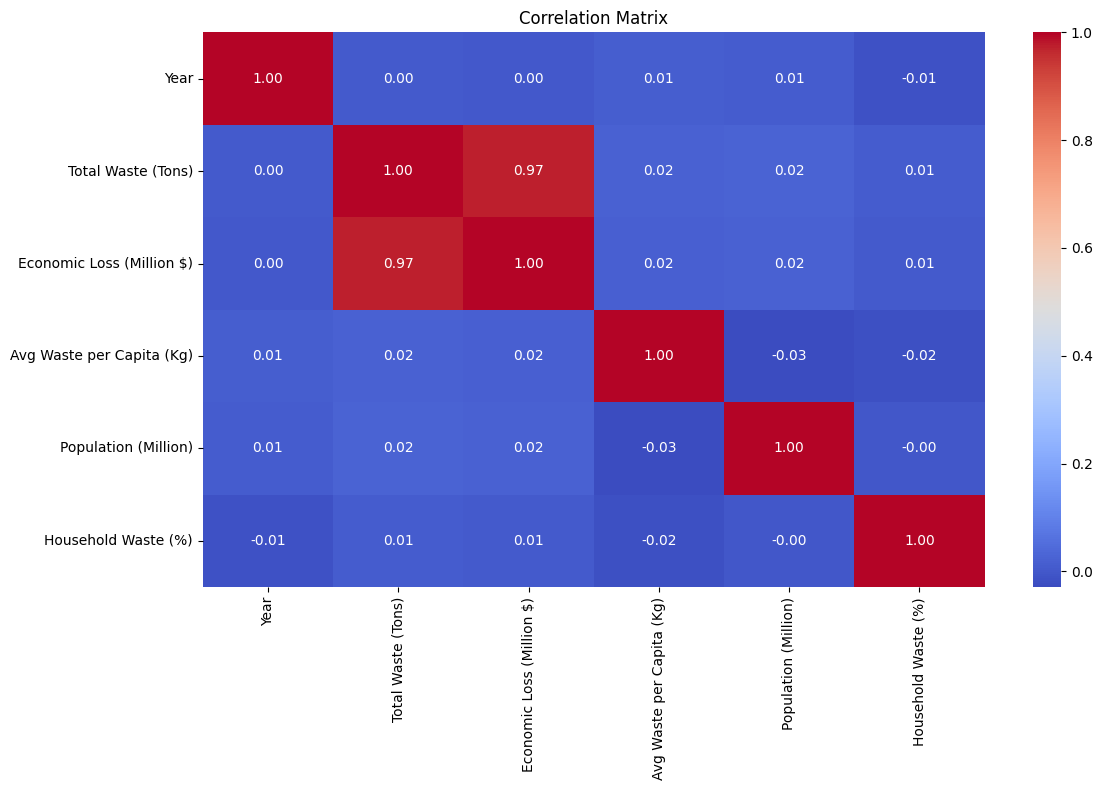

In [35]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')

/var/folders/1q/461kwq6d42j7t8d6yytb5nyw0000gp/T/ipykernel_49294/1630366491.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/var/folders/1q/461kwq6d42j7t8d6yytb5nyw0000gp/T/ipykernel_49294/1630366491.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


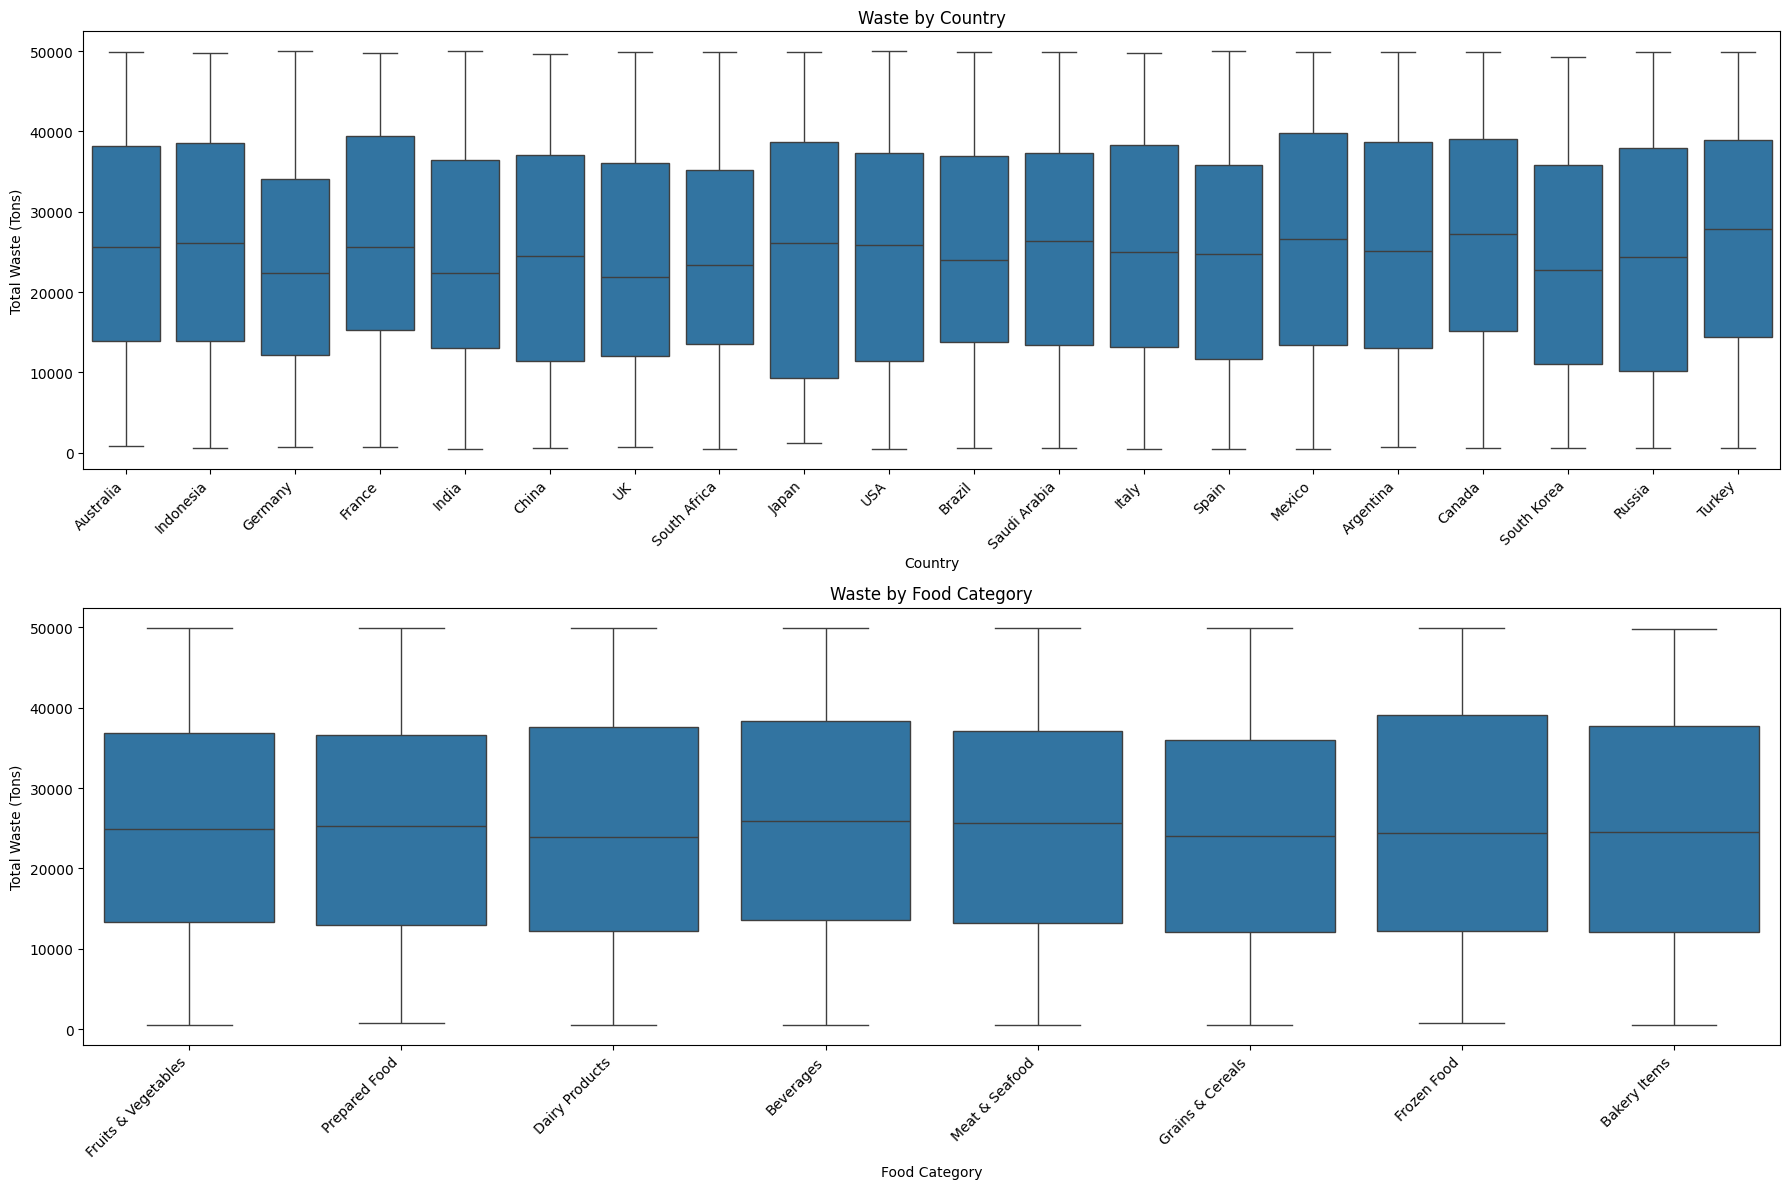

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.boxplot(x=col, y='Total Waste (Tons)', data=df, ax=axes[i])
    axes[i].set_title(f'Waste by {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('categorical_boxplots.png')

In [37]:
with mlflow.start_run(run_name="Data_Exploration"):
    # Log the dataset metrics
    # mlflow.log_param("dataset_size", df.shape[0])
    # mlflow.log_param("num_features", df.shape[1])
    
    # Log some basic stats
    # mlflow.log_metric("Average Economic Loss", df['Economic Loss (Million $)'].mean())
    # mlflow.log_metric("Average Household Waste", df['Household Waste (%)'].mean())
    
    # Log the correlation matrix as an artifact
    mlflow.log_artifact('correlation_matrix.png')
    mlflow.log_artifact('categorical_boxplots.png')

In [43]:
#mlflow.end_run()

In [38]:
df['Year Difference'] = df['Year'] - 2019
df['Economic Loss per Capita'] = df['Economic Loss (Million $)'] / df['Population (Million)']
df['Total Waste per Household'] = df['Total Waste (Tons)'] * (df['Household Waste (%)'] / 100)
df['Average Economic Loss per Ton'] = df['Economic Loss (Million $)'] / df['Total Waste (Tons)']

# One-Hot Encoding
df = pd.get_dummies(df, columns=['Country', 'Food Category'])

# Normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Total Waste (Tons)', 'Economic Loss (Million $)', 'Avg Waste per Capita (Kg)']] = scaler.fit_transform(df[['Total Waste (Tons)', 'Economic Loss (Million $)', 'Avg Waste per Capita (Kg)']])

In [39]:
df

,Year,Total Waste (Tons),Economic Loss (Million $),Avg Waste per Capita (Kg),Population (Million),Household Waste (%),Year Difference,Economic Loss per Capita,Total Waste per Household,Average Economic Loss per Ton,...,Country_UK,Country_USA,Food Category_Bakery Items,Food Category_Beverages,Food Category_Dairy Products,Food Category_Frozen Food,Food Category_Fruits & Vegetables,Food Category_Grains & Cereals,Food Category_Meat & Seafood,Food Category_Prepared Food
0,2019,-0.406717,-0.434580,-0.708165,87.59,53.64,0,213.342619,10335.693132,0.969798,...,False,False,False,False,False,False,True,False,False,False
1,2019,-1.484503,-1.412240,1.599429,1153.99,30.61,0,3.808075,1198.984517,1.121908,...,False,False,False,False,False,False,False,False,False,True
2,2022,-1.078486,-1.103413,1.106829,1006.11,48.08,3,8.855056,4663.836928,0.918455,...,False,False,False,False,True,False,False,False,False,False
3,2023,1.491039,1.061068,0.206554,953.05,31.91,4,42.548890,14774.231079,0.875842,...,False,False,False,False,False,False,True,False,False,False
4,2023,0.564094,0.816834,-0.090971,1105.47,36.06,4,33.452577,11934.623142,1.117361,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2021,1.577046,1.574598,-0.617271,1087.46,39.73,2,44.193258,18881.579202,1.011229,...,False,False,False,True,False,False,False,False,False,False
4996,2021,0.510818,0.524351,1.634670,1336.32,64.83,2,24.473988,20964.543876,1.011360,...,False,False,False,True,False,False,False,False,False,False
4997,2018,-0.310370,-0.174732,-1.702801,16.13,31.23,-1,1394.006820,6446.171808,1.089355,...,False,False,False,False,False,False,False,False,True,False
4998,2021,0.105651,0.295364,1.688398,1086.17,69.95,2,27.028522,18583.364680,1.105054,...,False,False,False,True,False,False,False,False,False,False


In [40]:
target = 'Total Waste (Tons)'

In [41]:
X = df.drop(columns=[target])
y = df[target]

In [42]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [43]:
with mlflow.start_run(run_name="Data_Preprocessing"):
    # Log the dataset versions
    # mlflow.log_param("train_size", X_train.shape[0])
    # mlflow.log_param("validation_size", X_val.shape[0])
    # mlflow.log_param("test_size", X_test.shape[0])
    # mlflow.log_param("num_features_after_engineering", X_train.shape[1])
    
    # We can also log the actual datasets as artifacts
    X_train.to_csv("X_train.csv", index=False)
    y_train.to_csv("y_train.csv", index=False)
    X_val.to_csv("X_val.csv", index=False)
    y_val.to_csv("y_val.csv", index=False)
    X_test.to_csv("X_test.csv", index=False)
    y_test.to_csv("y_test.csv", index=False)
    
    mlflow.log_artifact("X_train.csv", artifact_path="train_data")
    mlflow.log_artifact("y_train.csv", artifact_path="train_data")
    mlflow.log_artifact("X_val.csv", artifact_path="val_data")
    mlflow.log_artifact("y_val.csv", artifact_path="val_data")
    mlflow.log_artifact("X_test.csv", artifact_path="test_data")
    mlflow.log_artifact("y_test.csv", artifact_path="test_data")

In [45]:
# Define hyperparameter search spaces
search_space_lr = {
    'fit_intercept': hp.choice('fit_intercept', [True, False])
}

search_space_dt = {
    'max_depth': hp.quniform('max_depth', 10, 30, 10),  # Returns 10, 20, or 30
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 0.2)
}

search_space_rf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 50),  # Returns 50, 100, 150, 200
    'max_depth': hp.quniform('max_depth', 10, 30, 10),  # Returns 10, 20, or 30
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 0.2)
}

# Create parent MLflow run
with mlflow.start_run(run_name="Model_Experiments") as parent_run:
    #mlflow.log_param("experiment_type", "regression_models")
    
    # List to store all models and their performance
    all_models = []
    
    # Hyperparameter tuning functions for each model type with MLflow logging
    def tune_lr(params):
        with mlflow.start_run(run_name="LinearRegression", nested=True) as run:
            fit_intercept = [True, False][int(params['fit_intercept'])]
            
            # Log parameters
            mlflow.log_param("fit_intercept", fit_intercept)
            mlflow.log_param("model_type", "LinearRegression")
            mlflow.log_param("feature_selection", False)
            
            # Train model
            model = LinearRegression(fit_intercept=fit_intercept)
            model.fit(X_train, y_train)
            
            # Evaluate and log metrics
            predictions = model.predict(X_val)
            mse = mean_squared_error(y_val, predictions)
            mlflow.log_metric("mse", mse)
            
            # Log model
            mlflow.sklearn.log_model(model, "model")
            
            # Store model info
            all_models.append({
                'run_id': run.info.run_id,
                'model_type': "LinearRegression",
                'params': {'fit_intercept': fit_intercept},
                'model': copy.deepcopy(model),
                'mse': mse,
                'feature_selection': False
            })
            
            return mse

    def tune_dt(params):
        with mlflow.start_run(run_name="DecisionTree", nested=True) as run:
            max_depth = int(params['max_depth'])
            min_samples_split = params['min_samples_split']
            
            # Log parameters
            mlflow.log_param("max_depth", max_depth)
            mlflow.log_param("min_samples_split", min_samples_split)
            mlflow.log_param("model_type", "DecisionTree")
            mlflow.log_param("feature_selection", False)
            
            # Train model
            model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)
            model.fit(X_train, y_train)
            
            # Evaluate and log metrics
            predictions = model.predict(X_val)
            mse = mean_squared_error(y_val, predictions)
            mlflow.log_metric("mse", mse)
            
            # Log model
            mlflow.sklearn.log_model(model, "model")
            
            # Store model info
            all_models.append({
                'run_id': run.info.run_id,
                'model_type': "DecisionTree",
                'params': {
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split
                },
                'model': copy.deepcopy(model),
                'mse': mse,
                'feature_selection': False
            })
            
            return mse

    def tune_rf(params):
        with mlflow.start_run(run_name="RandomForest", nested=True) as run:
            n_estimators = int(params['n_estimators'])
            max_depth = int(params['max_depth'])
            min_samples_split = params['min_samples_split']
            
            # Log parameters
            mlflow.log_param("n_estimators", n_estimators)
            mlflow.log_param("max_depth", max_depth)
            mlflow.log_param("min_samples_split", min_samples_split)
            mlflow.log_param("model_type", "RandomForest")
            mlflow.log_param("feature_selection", False)
            
            # Train model
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            model.fit(X_train, y_train)
            
            # Evaluate and log metrics
            predictions = model.predict(X_val)
            mse = mean_squared_error(y_val, predictions)
            mlflow.log_metric("mse", mse)
            
            # Log model
            mlflow.sklearn.log_model(model, "model")
            
            # Store model info
            all_models.append({
                'run_id': run.info.run_id,
                'model_type': "RandomForest",
                'params': {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split
                },
                'model': copy.deepcopy(model),
                'mse': mse,
                'feature_selection': False
            })
            
            return mse

    # Stage 1: Hyperparameter tuning for each model type using all features
    print("Stage 1: Hyperparameter tuning with all features")
    best_lr_params = fmin(fn=tune_lr, space=search_space_lr, algo=tpe.suggest, max_evals=10)
    best_dt_params = fmin(fn=tune_dt, space=search_space_dt, algo=tpe.suggest, max_evals=10)
    best_rf_params = fmin(fn=tune_rf, space=search_space_rf, algo=tpe.suggest, max_evals=10)

    # Stage 2: Feature selection
    print("Stage 2: Performing feature selection")
    with mlflow.start_run(run_name="Feature_Selection", nested=True) as fs_run:
        selector = SelectKBest(f_regression, k=5)  # Select top 5 features
        
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_val_selected = selector.transform(X_val)
        X_test_selected = selector.transform(X_test)
        
        # Log the selected features
        feature_indices = selector.get_support(indices=True)
        #mlflow.log_param("selected_features", feature_indices.tolist())
        
        # Get feature names if available
        try:
            if hasattr(X_train, 'columns'):
                feature_names = X_train.columns[feature_indices].tolist()
                #mlflow.log_param("selected_feature_names", feature_names)
                print(f"\nSelected Features: {feature_names}")
            else:
                print(f"\nSelected Feature Indices: {feature_indices.tolist()}")
        except:
            print(f"\nSelected Feature Indices: {feature_indices.tolist()}")

    # Stage 3: Hyperparameter tuning with feature selection
    print("\nStage 3: Hyperparameter tuning with selected features")
    def tune_lr_with_selected_features(params):
        with mlflow.start_run(run_name="LinearRegression_SelectedFeatures", nested=True) as run:
            fit_intercept = [True, False][int(params['fit_intercept'])]
            
            # Log parameters
            mlflow.log_param("fit_intercept", fit_intercept)
            mlflow.log_param("feature_selection", True)
            mlflow.log_param("model_type", "LinearRegression")
            
            # Train model
            model = LinearRegression(fit_intercept=fit_intercept)
            model.fit(X_train_selected, y_train)
            
            # Evaluate and log metrics
            predictions = model.predict(X_val_selected)
            mse = mean_squared_error(y_val, predictions)
            mlflow.log_metric("mse", mse)
            
            # Log model
            mlflow.sklearn.log_model(model, "model")
            
            # Store model info
            all_models.append({
                'run_id': run.info.run_id,
                'model_type': "LinearRegression",
                'params': {'fit_intercept': fit_intercept},
                'model': copy.deepcopy(model),
                'mse': mse,
                'feature_selection': True
            })
            
            return mse

    def tune_dt_with_selected_features(params):
        with mlflow.start_run(run_name="DecisionTree_SelectedFeatures", nested=True) as run:
            max_depth = int(params['max_depth'])
            min_samples_split = params['min_samples_split']
            
            # Log parameters
            mlflow.log_param("max_depth", max_depth)
            mlflow.log_param("min_samples_split", min_samples_split)
            mlflow.log_param("feature_selection", True)
            mlflow.log_param("model_type", "DecisionTree")
            
            # Train model
            model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)
            model.fit(X_train_selected, y_train)
            
            # Evaluate and log metrics
            predictions = model.predict(X_val_selected)
            mse = mean_squared_error(y_val, predictions)
            mlflow.log_metric("mse", mse)
            
            # Log model
            mlflow.sklearn.log_model(model, "model")
            
            # Store model info
            all_models.append({
                'run_id': run.info.run_id,
                'model_type': "DecisionTree",
                'params': {
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split
                },
                'model': copy.deepcopy(model),
                'mse': mse,
                'feature_selection': True
            })
            
            return mse

    def tune_rf_with_selected_features(params):
        with mlflow.start_run(run_name="RandomForest_SelectedFeatures", nested=True) as run:
            n_estimators = int(params['n_estimators'])
            max_depth = int(params['max_depth'])
            min_samples_split = params['min_samples_split']
            
            # Log parameters
            mlflow.log_param("n_estimators", n_estimators)
            mlflow.log_param("max_depth", max_depth)
            mlflow.log_param("min_samples_split", min_samples_split)
            mlflow.log_param("feature_selection", True)
            mlflow.log_param("model_type", "RandomForest")
            
            # Train model
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            model.fit(X_train_selected, y_train)
            
            # Evaluate and log metrics
            predictions = model.predict(X_val_selected)
            mse = mean_squared_error(y_val, predictions)
            mlflow.log_metric("mse", mse)
            
            # Log model
            mlflow.sklearn.log_model(model, "model")
            
            # Store model info
            all_models.append({
                'run_id': run.info.run_id,
                'model_type': "RandomForest",
                'params': {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split
                },
                'model': copy.deepcopy(model),
                'mse': mse,
                'feature_selection': True
            })
            
            return mse

    # Hyperparameter tuning for each model with selected features
    best_lr_params_selected = fmin(
        fn=tune_lr_with_selected_features, 
        space=search_space_lr, 
        algo=tpe.suggest, 
        max_evals=10
    )
    best_dt_params_selected = fmin(
        fn=tune_dt_with_selected_features, 
        space=search_space_dt, 
        algo=tpe.suggest, 
        max_evals=10
    )
    best_rf_params_selected = fmin(
        fn=tune_rf_with_selected_features, 
        space=search_space_rf, 
        algo=tpe.suggest, 
        max_evals=10
    )

    # Filter only models with feature selection
    models_with_feature_selection = [model for model in all_models if model['feature_selection']]
    
    # Sort models with feature selection by MSE (ascending)
    sorted_feature_selection_models = sorted(models_with_feature_selection, key=lambda x: x['mse'])
    
    # Get the top 3 feature selection models
    top_3_feature_selection_models = sorted_feature_selection_models[:3]
    
    # Print detailed information about top 3 feature selection models
    print("\n======== Top 3 Models with Feature Selection ========")
    for i, model_info in enumerate(top_3_feature_selection_models):
        rank = i + 1
        model_type = model_info['model_type']
        mse = model_info['mse']
        params = model_info['params']
        
        print(f"\n{rank}. {model_type} - Validation MSE: {mse:.6f}")
        print("   Parameters:")
        
        # Format parameters based on model type
        if model_type == "LinearRegression":
            print(f"   - fit_intercept: {params['fit_intercept']}")
        elif model_type == "DecisionTree":
            print(f"   - max_depth: {params['max_depth']}")
            print(f"   - min_samples_split: {params['min_samples_split']:.6f}")
        elif model_type == "RandomForest":
            print(f"   - n_estimators: {params['n_estimators']}")
            print(f"   - max_depth: {params['max_depth']}")
            print(f"   - min_samples_split: {params['min_samples_split']:.6f}")
        
        # Log to MLflow
        #mlflow.log_param(f"top_{rank}_feature_selection_model_type", model_type)
        #mlflow.log_param(f"top_{rank}_feature_selection_model_run_id", model_info['run_id'])
        #mlflow.log_metric(f"top_{rank}_feature_selection_model_mse", mse)
        
        # Log each parameter
        # for param_name, param_value in params.items():
        #     mlflow.log_param(f"top_{rank}_feature_selection_{param_name}", param_value)
    
    # Select the best model among the top 3 feature selection models
    best_feature_selection_model = top_3_feature_selection_models[0]
    
    # Train the best model on combined training + validation data and evaluate on test
    with mlflow.start_run(run_name="Best_Feature_Selection_Model_Final", nested=True) as final_run:
        # Log all parameters of the best model
        # for param_name, param_value in best_feature_selection_model['params'].items():
        #     mlflow.log_param(param_name, param_value)
        
        # mlflow.log_param("model_type", best_feature_selection_model['model_type'])
        # mlflow.log_param("validation_mse", best_feature_selection_model['mse'])
        
        # Combine train and validation sets for final training
        X_train_val = np.vstack((X_train_selected, X_val_selected))
        y_train_val = np.concatenate((y_train, y_val))
        
        # Train the final model on combined training and validation data
        model_final = copy.deepcopy(best_feature_selection_model['model'])
        model_final.fit(X_train_val, y_train_val)
        
        # Evaluate on test set
        test_predictions = model_final.predict(X_test_selected)
        test_mse = mean_squared_error(y_test, test_predictions)
        
        # # Log metrics
        # mlflow.log_metric("test_mse", test_mse)
        
        # # Log model
        # mlflow.sklearn.log_model(model_final, "best_feature_selection_model")
        
        # # Also log to the parent run
        # mlflow.log_metric("best_feature_selection_model_test_mse", test_mse)
        
        # Print final results with detailed information
        print("\n======== Final Selected Model ========")
        print(f"Model Type: {best_feature_selection_model['model_type']}")
        print(f"Parameters:")
        for param_name, param_value in best_feature_selection_model['params'].items():
            print(f"- {param_name}: {param_value}")
        print(f"Validation MSE: {best_feature_selection_model['mse']:.6f}")
        print(f"Test MSE: {test_mse:.6f}")

Stage 1: Hyperparameter tuning with all features
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2025/03/24 23:42:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 10%|█         | 1/10 [00:02<00:21,  2.36s/trial, best loss: 0.011334648236856735]

2025/03/24 23:42:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 20%|██        | 2/10 [00:03<00:13,  1.68s/trial, best loss: 0.011334648236856735]

2025/03/24 23:42:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 30%|███       | 3/10 [00:04<00:10,  1.45s/trial, best loss: 0.011334648236856735]

2025/03/24 23:42:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 40%|████      | 4/10 [00:05<00:07,  1.33s/trial, best loss: 0.011334648236856735]

2025/03/24 23:42:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 5/10 [00:07<00:06,  1.28s/trial, best loss: 0.011334648236856735]

2025/03/24 23:42:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 60%|██████    | 6/10 [00:08<00:04,  1.22s/trial, best loss: 0.011334648236856735]

2025/03/24 23:42:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 70%|███████   | 7/10 [00:09<00:03,  1.31s/trial, best loss: 0.011334648236856735]

2025/03/24 23:42:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 80%|████████  | 8/10 [00:10<00:02,  1.27s/trial, best loss: 0.011334648236856735]

2025/03/24 23:42:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 90%|█████████ | 9/10 [00:12<00:01,  1.24s/trial, best loss: 0.011334648236856735]

2025/03/24 23:42:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2025/03/24 23:42:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 10%|█         | 1/10 [00:01<00:16,  1.82s/trial, best loss: 0.013619191890294929]

2025/03/24 23:42:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 20%|██        | 2/10 [00:02<00:11,  1.40s/trial, best loss: 0.013619191890294929]

2025/03/24 23:42:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 30%|███       | 3/10 [00:03<00:08,  1.22s/trial, best loss: 0.013619191890294929]

2025/03/24 23:42:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 40%|████      | 4/10 [00:05<00:07,  1.20s/trial, best loss: 0.01249457025934055] 

2025/03/24 23:42:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 5/10 [00:06<00:05,  1.17s/trial, best loss: 0.004004834507688836]

2025/03/24 23:42:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 60%|██████    | 6/10 [00:07<00:04,  1.16s/trial, best loss: 0.004004834507688836]

2025/03/24 23:42:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 70%|███████   | 7/10 [00:08<00:03,  1.20s/trial, best loss: 0.004004834507688836]

2025/03/24 23:42:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 80%|████████  | 8/10 [00:09<00:02,  1.16s/trial, best loss: 0.004004834507688836]

2025/03/24 23:42:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 90%|█████████ | 9/10 [00:10<00:01,  1.19s/trial, best loss: 0.004004834507688836]

2025/03/24 23:42:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2025/03/24 23:42:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 10%|█         | 1/10 [00:02<00:18,  2.08s/trial, best loss: 0.022372326436235587]

2025/03/24 23:42:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 20%|██        | 2/10 [00:04<00:18,  2.33s/trial, best loss: 0.022372326436235587]

2025/03/24 23:42:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 30%|███       | 3/10 [00:07<00:16,  2.40s/trial, best loss: 0.022372326436235587]

2025/03/24 23:42:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 40%|████      | 4/10 [00:08<00:12,  2.15s/trial, best loss: 0.022372326436235587]

2025/03/24 23:42:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 5/10 [00:10<00:10,  2.03s/trial, best loss: 0.022372326436235587]

2025/03/24 23:42:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 60%|██████    | 6/10 [00:12<00:08,  2.03s/trial, best loss: 0.0058250401682121405]

2025/03/24 23:43:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 70%|███████   | 7/10 [00:15<00:06,  2.19s/trial, best loss: 0.0058250401682121405]

2025/03/24 23:43:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 80%|████████  | 8/10 [00:17<00:04,  2.12s/trial, best loss: 0.0058250401682121405]

2025/03/24 23:43:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 90%|█████████ | 9/10 [00:18<00:01,  1.97s/trial, best loss: 0.0058250401682121405]

2025/03/24 23:43:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



100%|██████████| 10/10 [00:20<00:00,  2.03s/trial, best loss: 0.0058250401682121405]
Stage 2: Performing feature selection

Selected Features: ['Economic Loss (Million $)', 'Economic Loss per Capita', 'Total Waste per Household', 'Country_France', 'Country_South Korea']

Stage 3: Hyperparameter tuning with selected features
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2025/03/24 23:43:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 10%|█         | 1/10 [00:01<00:10,  1.21s/trial, best loss: 0.04769740163135214]

2025/03/24 23:43:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 20%|██        | 2/10 [00:02<00:08,  1.08s/trial, best loss: 0.04769740163135214]

2025/03/24 23:43:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 30%|███       | 3/10 [00:03<00:07,  1.03s/trial, best loss: 0.04769740163135214]

2025/03/24 23:43:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 40%|████      | 4/10 [00:04<00:06,  1.02s/trial, best loss: 0.04769740163135214]

2025/03/24 23:43:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 5/10 [00:05<00:04,  1.00trial/s, best loss: 0.04769740163135214]

2025/03/24 23:43:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 60%|██████    | 6/10 [00:06<00:03,  1.01trial/s, best loss: 0.04769740163135214]

2025/03/24 23:43:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 70%|███████   | 7/10 [00:07<00:02,  1.02trial/s, best loss: 0.04020764648752911]

2025/03/24 23:43:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 80%|████████  | 8/10 [00:08<00:01,  1.03trial/s, best loss: 0.04020764648752911]

2025/03/24 23:43:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 90%|█████████ | 9/10 [00:09<00:01,  1.03s/trial, best loss: 0.04020764648752911]

2025/03/24 23:43:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2025/03/24 23:43:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 10%|█         | 1/10 [00:01<00:09,  1.07s/trial, best loss: 0.05555344565109777]

2025/03/24 23:43:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 20%|██        | 2/10 [00:02<00:08,  1.02s/trial, best loss: 0.05555344565109776]

2025/03/24 23:43:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 30%|███       | 3/10 [00:03<00:07,  1.02s/trial, best loss: 0.03692671644980041]

2025/03/24 23:43:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 40%|████      | 4/10 [00:04<00:06,  1.14s/trial, best loss: 0.03692671644980041]

2025/03/24 23:43:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 5/10 [00:05<00:06,  1.25s/trial, best loss: 0.036527394948381565]

2025/03/24 23:43:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 60%|██████    | 6/10 [00:07<00:04,  1.23s/trial, best loss: 0.036527394948381565]

2025/03/24 23:43:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 70%|███████   | 7/10 [00:08<00:03,  1.17s/trial, best loss: 0.036461665528172434]

2025/03/24 23:43:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 80%|████████  | 8/10 [00:09<00:02,  1.40s/trial, best loss: 0.036461665528172434]

2025/03/24 23:43:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 90%|█████████ | 9/10 [00:12<00:01,  1.78s/trial, best loss: 0.036289032321449706]

2025/03/24 23:43:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2025/03/24 23:43:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 10%|█         | 1/10 [00:01<00:13,  1.45s/trial, best loss: 0.06996080323716983]

2025/03/24 23:43:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 20%|██        | 2/10 [00:02<00:10,  1.30s/trial, best loss: 0.06996080323716983]

2025/03/24 23:43:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 30%|███       | 3/10 [00:04<00:09,  1.40s/trial, best loss: 0.04926526984612965]

2025/03/24 23:43:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 40%|████      | 4/10 [00:05<00:08,  1.40s/trial, best loss: 0.03390083834499362]

2025/03/24 23:43:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 5/10 [00:07<00:08,  1.61s/trial, best loss: 0.03390083834499362]

2025/03/24 23:43:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 60%|██████    | 6/10 [00:08<00:06,  1.51s/trial, best loss: 0.03334554745247369]

2025/03/24 23:43:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 70%|███████   | 7/10 [00:10<00:04,  1.57s/trial, best loss: 0.03320997967457869]

2025/03/24 23:43:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 80%|████████  | 8/10 [00:11<00:02,  1.42s/trial, best loss: 0.03320997967457869]

2025/03/24 23:43:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 90%|█████████ | 9/10 [00:13<00:01,  1.42s/trial, best loss: 0.03320997967457869]

2025/03/24 23:43:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



100%|██████████| 10/10 [00:14<00:00,  1.49s/trial, best loss: 0.03320997967457869]

======== Top 3 Models with Feature Selection ========

1. RandomForest - Validation MSE: 0.033210
   Parameters:
   - n_estimators: 200
   - max_depth: 30
   - min_samples_split: 0.028440

2. RandomForest - Validation MSE: 0.033346
   Parameters:
   - n_estimators: 50
   - max_depth: 30
   - min_samples_split: 0.026614

3. RandomForest - Validation MSE: 0.033901
   Parameters:
   - n_estimators: 100
   - max_depth: 10
   - min_samples_split: 0.036401

======== Final Selected Model ========
Model Type: RandomForest
Parameters:
- n_estimators: 200
- max_depth: 30
- min_samples_split: 0.0284402043501691
Validation MSE: 0.033210
Test MSE: 0.033425


In [46]:
logged_model = 'mlruns/3/ec7ed9fbc7ba4053b83debe9f819e11b/artifacts/model' #replace with one of your models

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.sklearn
  run_id: ec7ed9fbc7ba4053b83debe9f819e11b

In [47]:
sklearn_model = mlflow.sklearn.load_model(logged_model)
sklearn_model

RandomForestRegressor(max_depth=30, min_samples_split=0.0284402043501691,
                      n_estimators=200, random_state=42)

In [48]:
sklearn_model.fit(X_train, y_train)
preds = sklearn_model.predict(X_test)
preds[:5]

array([-1.11013718, -1.45016908, -0.08864464, -0.80000669, -1.11575516])

In [50]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
mse

0.0062182440755284155

In [53]:
with mlflow.start_run():
    mlflow.log_param("model_name", "best_feature_selection_model")
    mlflow.log_metric("mse", mse)

In [52]:
runid = 'ec7ed9fbc7ba4053b83debe9f819e11b'
mod_path = f'runs:/{runid}/artifacts/better_models'
mlflow.register_model(model_uri = mod_path, name = 'food_wastage_model')

Successfully registered model 'food_wastage_model'.
Created version '1' of model 'food_wastage_model'.


<ModelVersion: aliases=[], creation_timestamp=1742885350111, current_stage='None', description=None, last_updated_timestamp=1742885350111, name='food_wastage_model', run_id='ec7ed9fbc7ba4053b83debe9f819e11b', run_link=None, source='/Users/samanvitha/mlops/notebooks/mlruns/3/ec7ed9fbc7ba4053b83debe9f819e11b/artifacts/artifacts/better_models', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression

In [58]:
df = pd.read_csv('/Users/samanvitha/mlops/data/freelancer_earnings_bd.csv')

In [59]:
df.head()

,Freelancer_ID,Job_Category,Platform,Experience_Level,Client_Region,Payment_Method,Job_Completed,Earnings_USD,Hourly_Rate,Job_Success_Rate,Client_Rating,Job_Duration_Days,Project_Type,Rehire_Rate,Marketing_Spend
0,1,Web Development,Fiverr,Beginner,Asia,Mobile Banking,180,1620,95.79,68.73,3.18,1,Fixed,40.19,53
1,2,App Development,Fiverr,Beginner,Australia,Mobile Banking,218,9078,86.38,97.54,3.44,54,Fixed,36.53,486
2,3,Web Development,Fiverr,Beginner,UK,Crypto,27,3455,85.17,86.60,4.20,46,Hourly,74.05,489
3,4,Data Entry,PeoplePerHour,Intermediate,Asia,Bank Transfer,17,5577,14.37,79.93,4.47,41,Hourly,27.58,67
4,5,Digital Marketing,Upwork,Expert,Asia,Crypto,245,5898,99.37,57.80,5.00,41,Hourly,69.09,489


In [60]:
df.shape

(1950, 15)

In [61]:
df.dtypes

Freelancer_ID          int64
Job_Category          object
Platform              object
Experience_Level      object
Client_Region         object
Payment_Method        object
Job_Completed          int64
Earnings_USD           int64
Hourly_Rate          float64
Job_Success_Rate     float64
Client_Rating        float64
Job_Duration_Days      int64
Project_Type          object
Rehire_Rate          float64
Marketing_Spend        int64
dtype: object

In [62]:
df.describe()

,Freelancer_ID,Job_Completed,Earnings_USD,Hourly_Rate,Job_Success_Rate,Client_Rating,Job_Duration_Days,Rehire_Rate,Marketing_Spend
count,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000,1950.000000
mean,975.500000,150.864103,5017.566667,52.579774,74.951846,3.995892,44.704615,44.556913,248.517436
std,563.060832,85.480770,2926.279918,26.927584,14.615735,0.575976,26.022998,20.193842,148.084581
min,1.000000,5.000000,51.000000,5.020000,50.160000,3.000000,1.000000,10.000000,0.000000
25%,488.250000,76.000000,2419.000000,30.047500,61.917500,3.510000,22.000000,27.150000,119.000000
50%,975.500000,149.000000,5048.000000,52.285000,75.400000,3.990000,45.000000,43.920000,252.500000
75%,1462.750000,225.000000,7608.250000,75.125000,87.537500,4.500000,67.000000,61.690000,379.000000
max,1950.000000,299.000000,9991.000000,99.830000,99.990000,5.000000,89.000000,79.950000,499.000000


In [63]:
df.isnull().sum()

Freelancer_ID        0
Job_Category         0
Platform             0
Experience_Level     0
Client_Region        0
Payment_Method       0
Job_Completed        0
Earnings_USD         0
Hourly_Rate          0
Job_Success_Rate     0
Client_Rating        0
Job_Duration_Days    0
Project_Type         0
Rehire_Rate          0
Marketing_Spend      0
dtype: int64

In [64]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment("Freelancer_Data")

<Experiment: artifact_location='/Users/samanvitha/mlops/notebooks/mlruns/3', creation_time=1742526284452, experiment_id='3', last_update_time=1742526284452, lifecycle_stage='active', name='Freelancer_Data', tags={}>

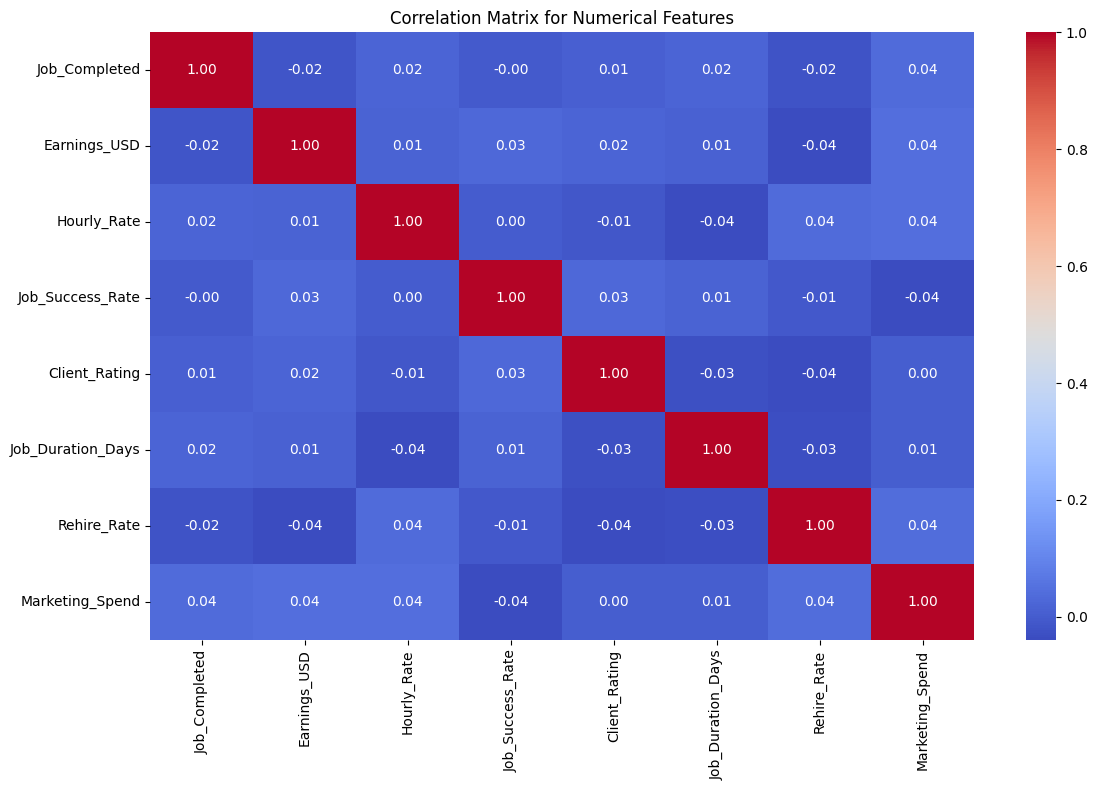

In [65]:
numeric_columns = ['Job_Completed', 'Earnings_USD', 'Hourly_Rate', 'Job_Success_Rate', 
                   'Client_Rating', 'Job_Duration_Days', 'Rehire_Rate', 'Marketing_Spend']

plt.figure(figsize=(12, 8))
corr_matrix = df[numeric_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Numerical Features')
plt.tight_layout()
plt.savefig('/Users/samanvitha/mlops/notebooks/images/correlation_matrix_num.png')

/var/folders/1q/461kwq6d42j7t8d6yytb5nyw0000gp/T/ipykernel_31057/2541258257.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/var/folders/1q/461kwq6d42j7t8d6yytb5nyw0000gp/T/ipykernel_31057/2541258257.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/var/folders/1q/461kwq6d42j7t8d6yytb5nyw0000gp/T/ipykernel_31057/2541258257.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/var/folders/1q/461kwq6d42j7t8d6yytb5nyw0000gp/T/ipykernel_31057/2541258257.py:10: UserWarning: set_ticklabels() should only be used 

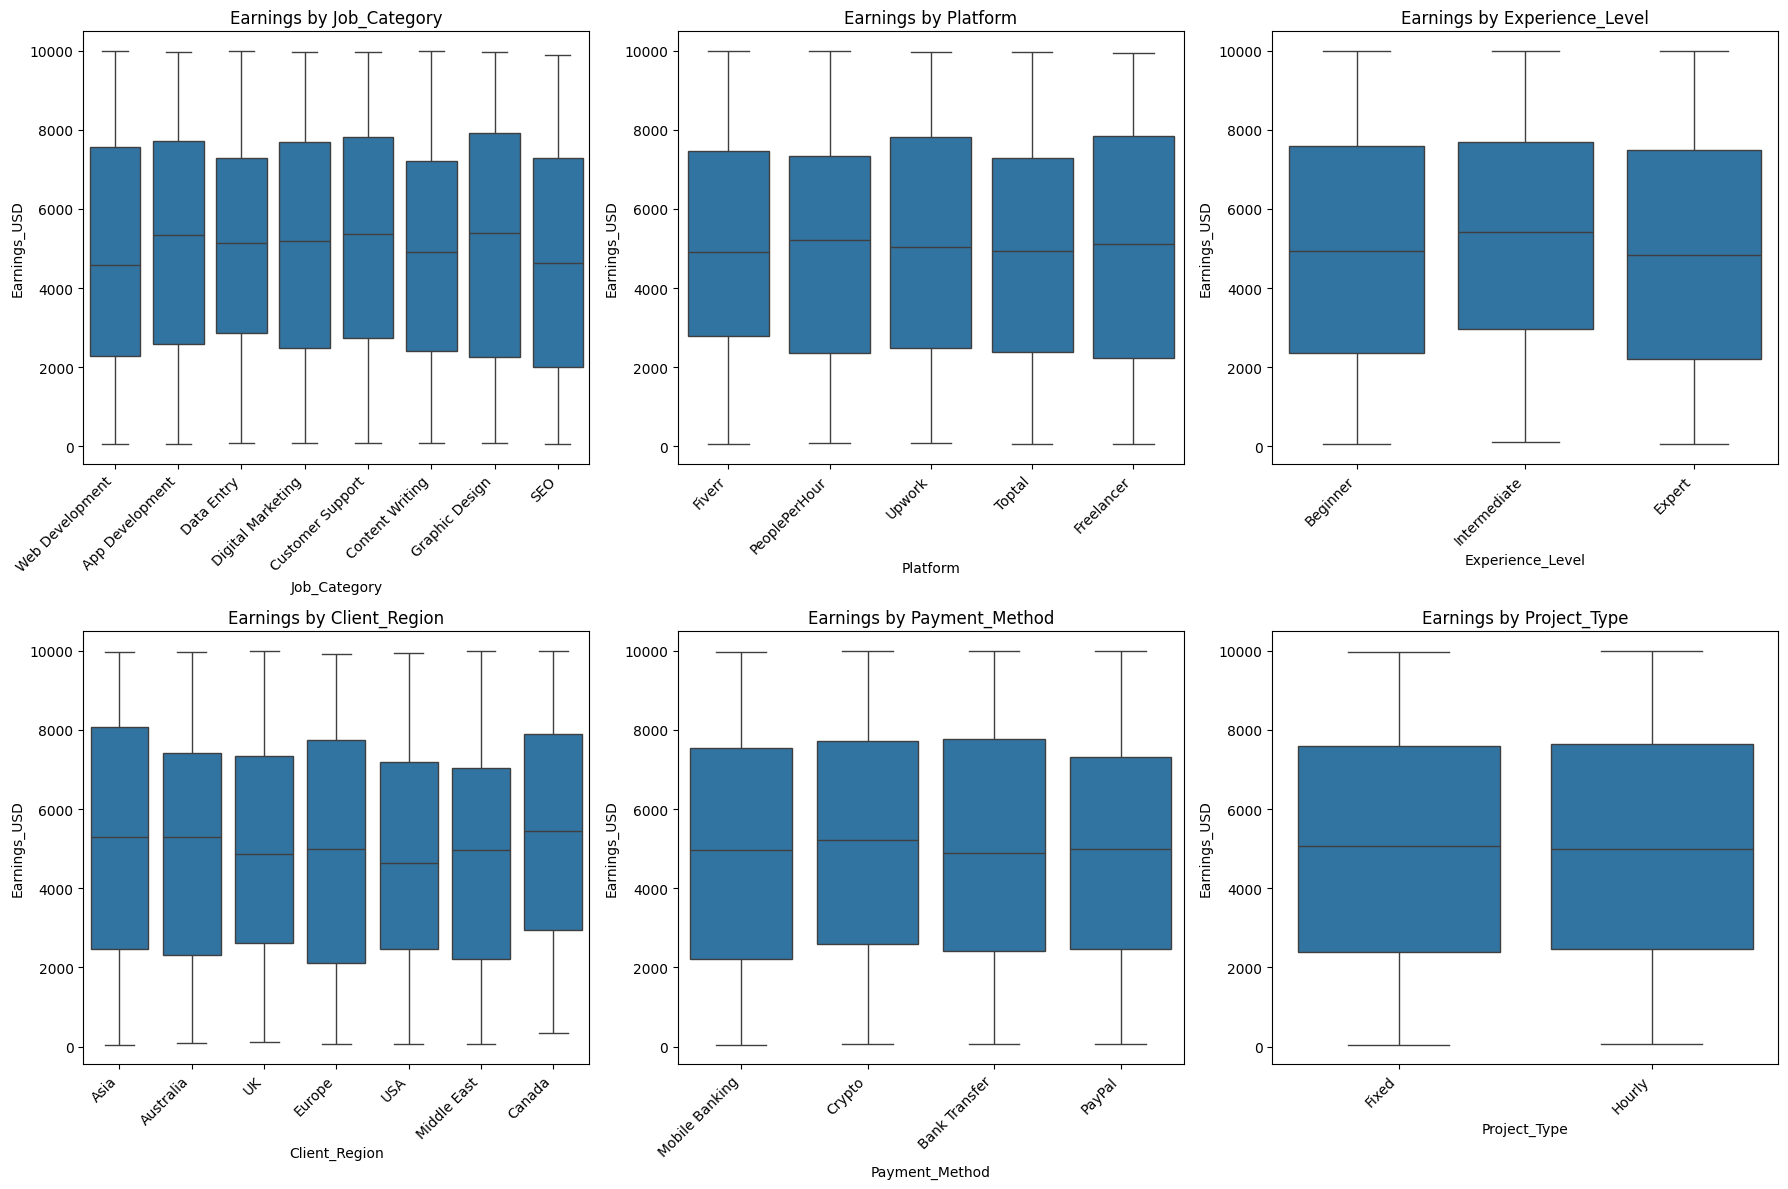

In [66]:
categorical_columns = ['Job_Category', 'Platform', 'Experience_Level', 
                       'Client_Region', 'Payment_Method', 'Project_Type']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='Earnings_USD', data=df, ax=axes[i])
    axes[i].set_title(f'Earnings by {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('/Users/samanvitha/mlops/notebooks/images/categorical_boxplots.png')

In [67]:
encoded_df = df.copy()
for col in categorical_columns:
    # Calculate mean earnings for each category
    means = df.groupby(col)['Earnings_USD'].mean()
    # Replace categories with their mean earnings
    encoded_df[f'{col}_encoded'] = df[col].map(means)

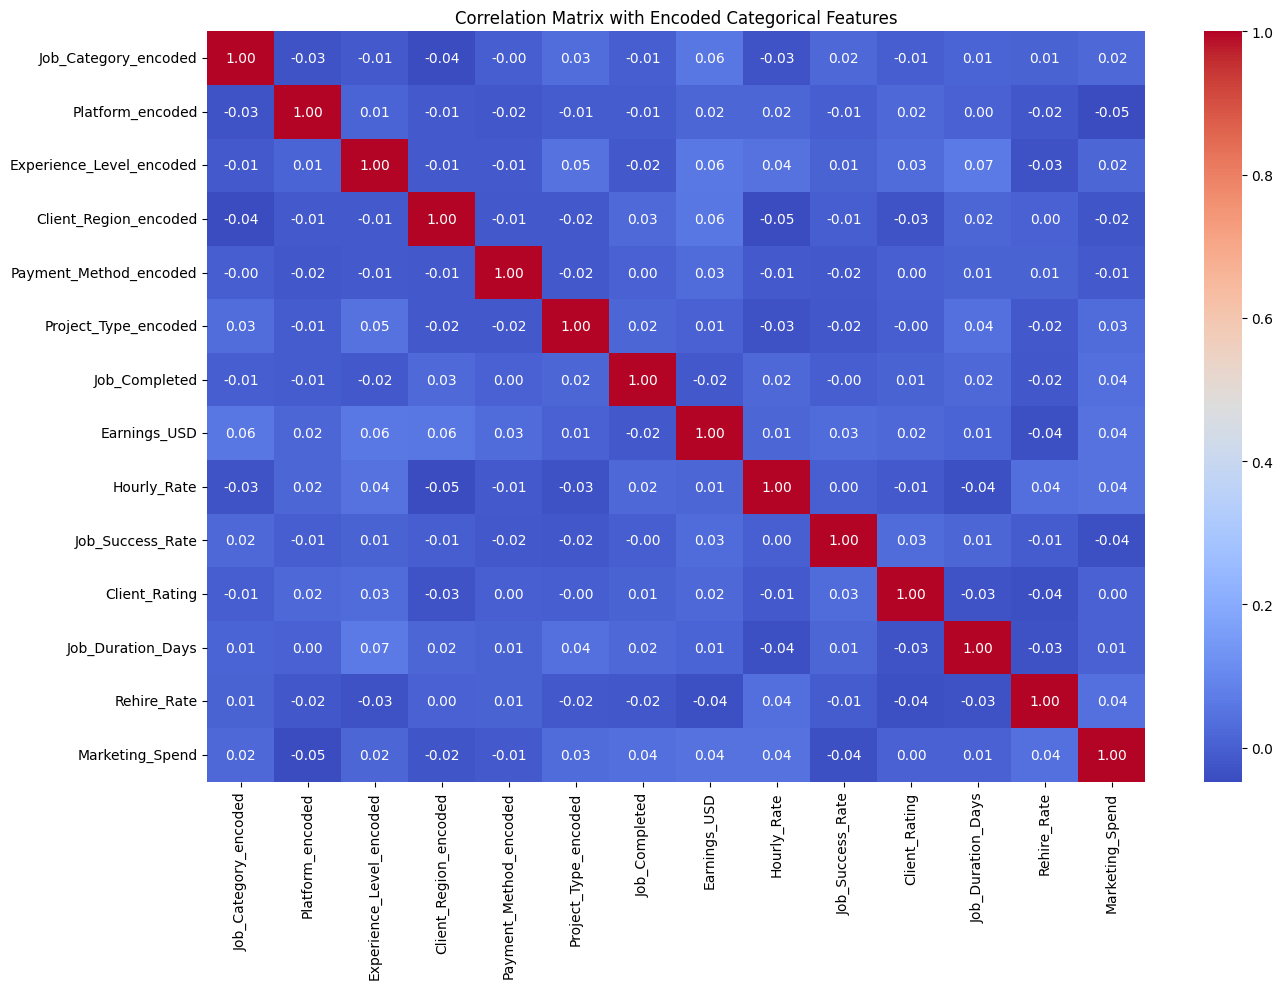

In [68]:
encoded_columns = [f'{col}_encoded' for col in categorical_columns] + numeric_columns
plt.figure(figsize=(14, 10))
encoded_corr = encoded_df[encoded_columns].corr()
sns.heatmap(encoded_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Encoded Categorical Features')
plt.tight_layout()
plt.savefig('/Users/samanvitha/mlops/notebooks/images/encoded_correlation_matrix.png')

/var/folders/1q/461kwq6d42j7t8d6yytb5nyw0000gp/T/ipykernel_31057/760697153.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/var/folders/1q/461kwq6d42j7t8d6yytb5nyw0000gp/T/ipykernel_31057/760697153.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/var/folders/1q/461kwq6d42j7t8d6yytb5nyw0000gp/T/ipykernel_31057/760697153.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/var/folders/1q/461kwq6d42j7t8d6yytb5nyw0000gp/T/ipykernel_31057/760697153.py:8: UserWarning: set_ticklabels() should only be used with a f

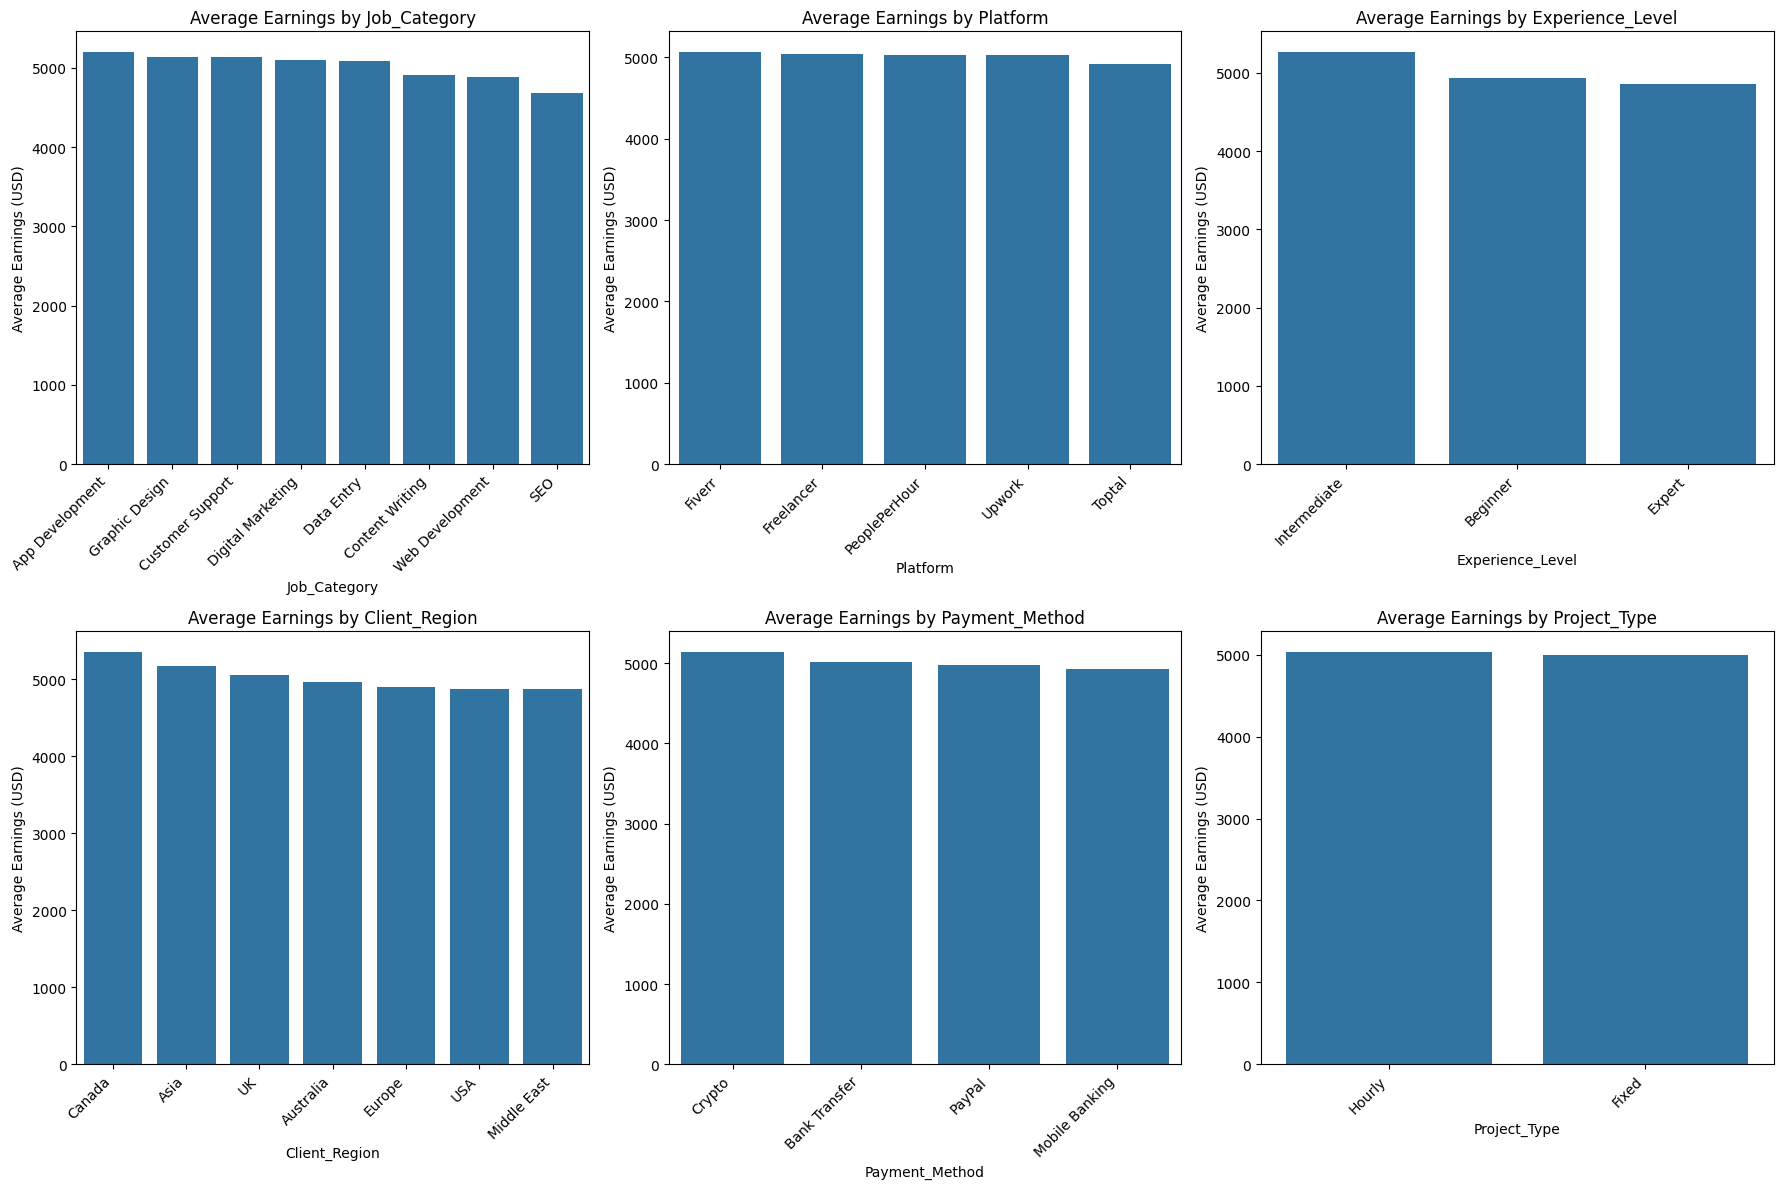

In [69]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    average_earnings = df.groupby(col)['Earnings_USD'].mean().sort_values(ascending=False)
    sns.barplot(x=average_earnings.index, y=average_earnings.values, ax=axes[i])
    axes[i].set_title(f'Average Earnings by {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_ylabel('Average Earnings (USD)')

plt.tight_layout()
plt.savefig('/Users/samanvitha/mlops/notebooks/images/categorical_barplots.png')

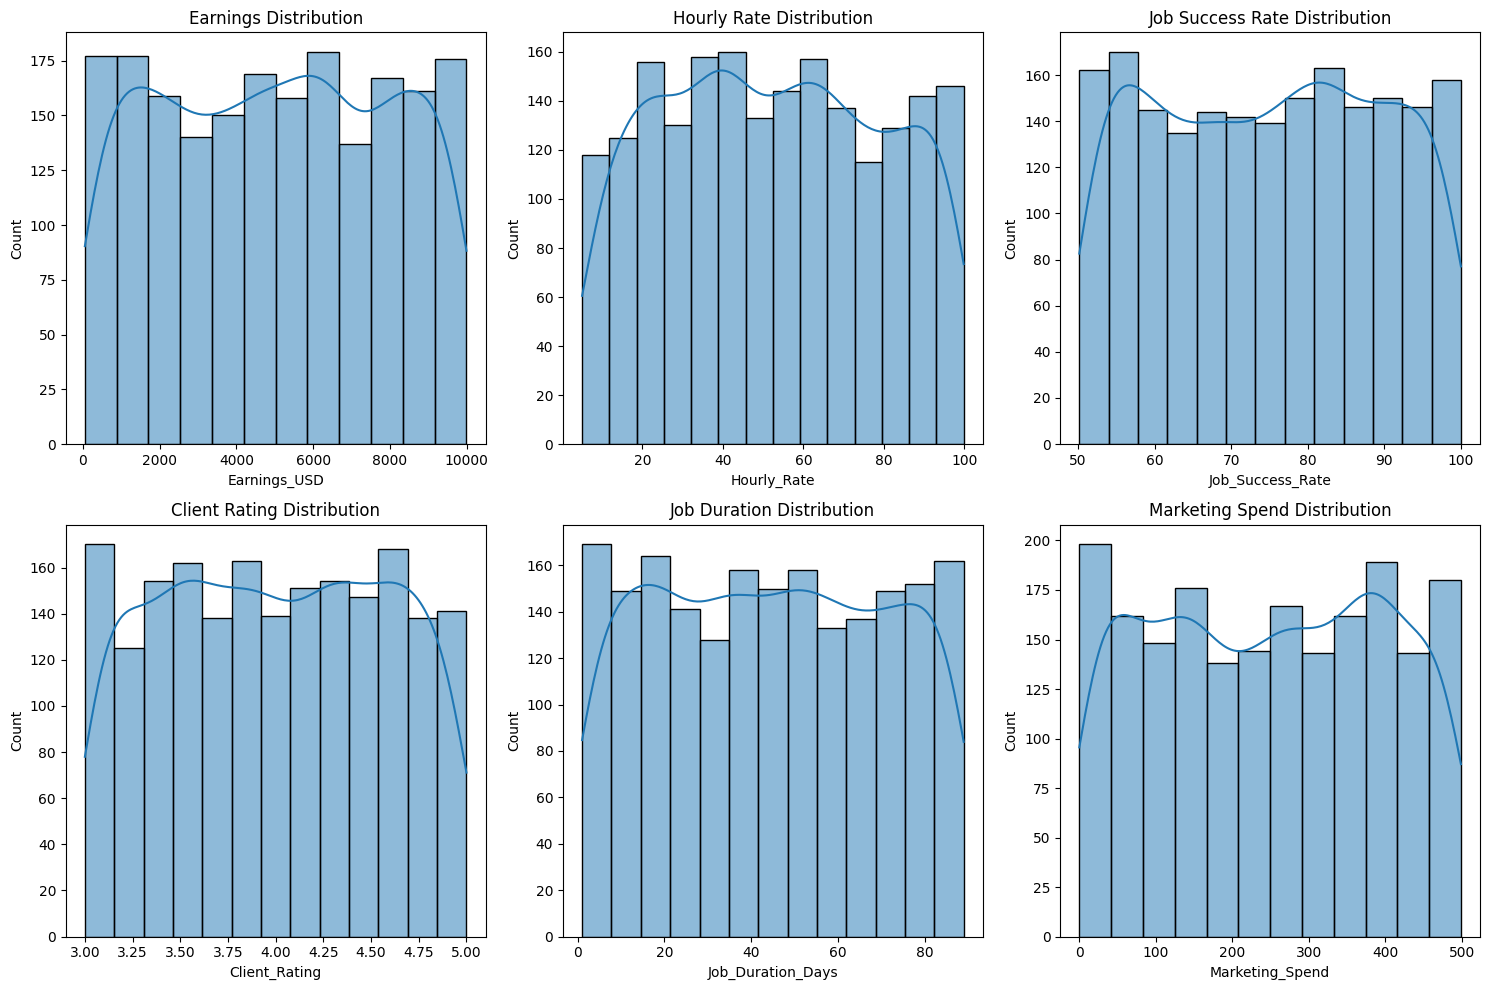

In [70]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.histplot(df['Earnings_USD'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Earnings Distribution')

sns.histplot(df['Hourly_Rate'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Hourly Rate Distribution')

sns.histplot(df['Job_Success_Rate'], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Job Success Rate Distribution')

sns.histplot(df['Client_Rating'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Client Rating Distribution')

sns.histplot(df['Job_Duration_Days'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Job Duration Distribution')

sns.histplot(df['Marketing_Spend'], kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Marketing Spend Distribution')

plt.tight_layout()
plt.savefig('/Users/samanvitha/mlops/notebooks/images/distributions.png')

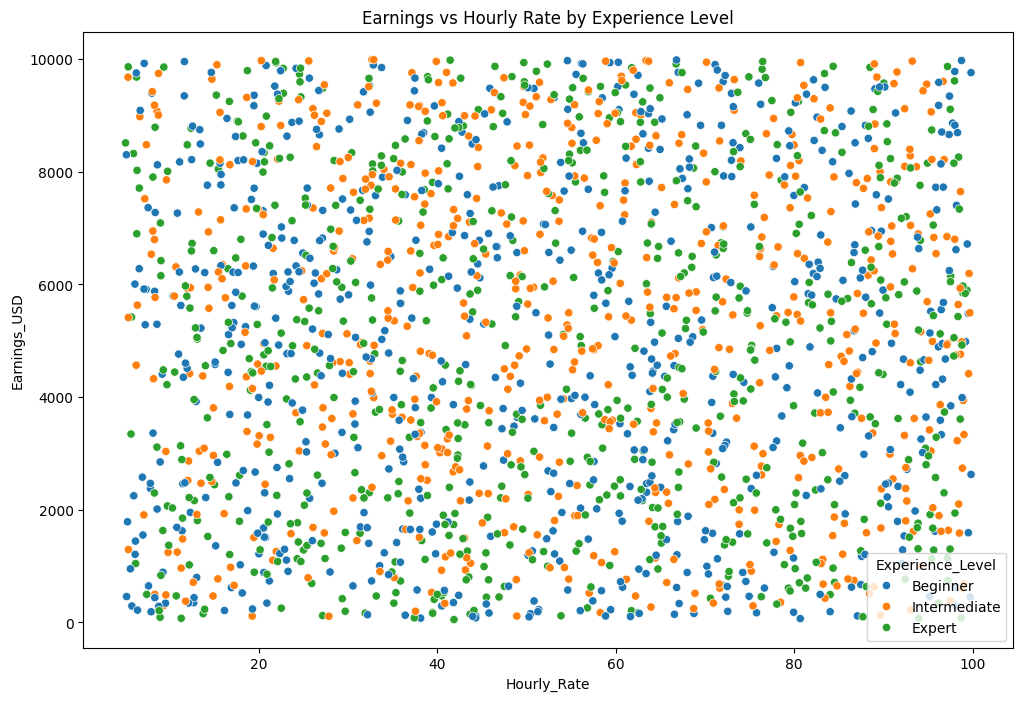

In [71]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Hourly_Rate', y='Earnings_USD', hue='Experience_Level', data=df)
plt.title('Earnings vs Hourly Rate by Experience Level')
plt.savefig('/Users/samanvitha/mlops/notebooks/images/earnings_vs_rate.png')

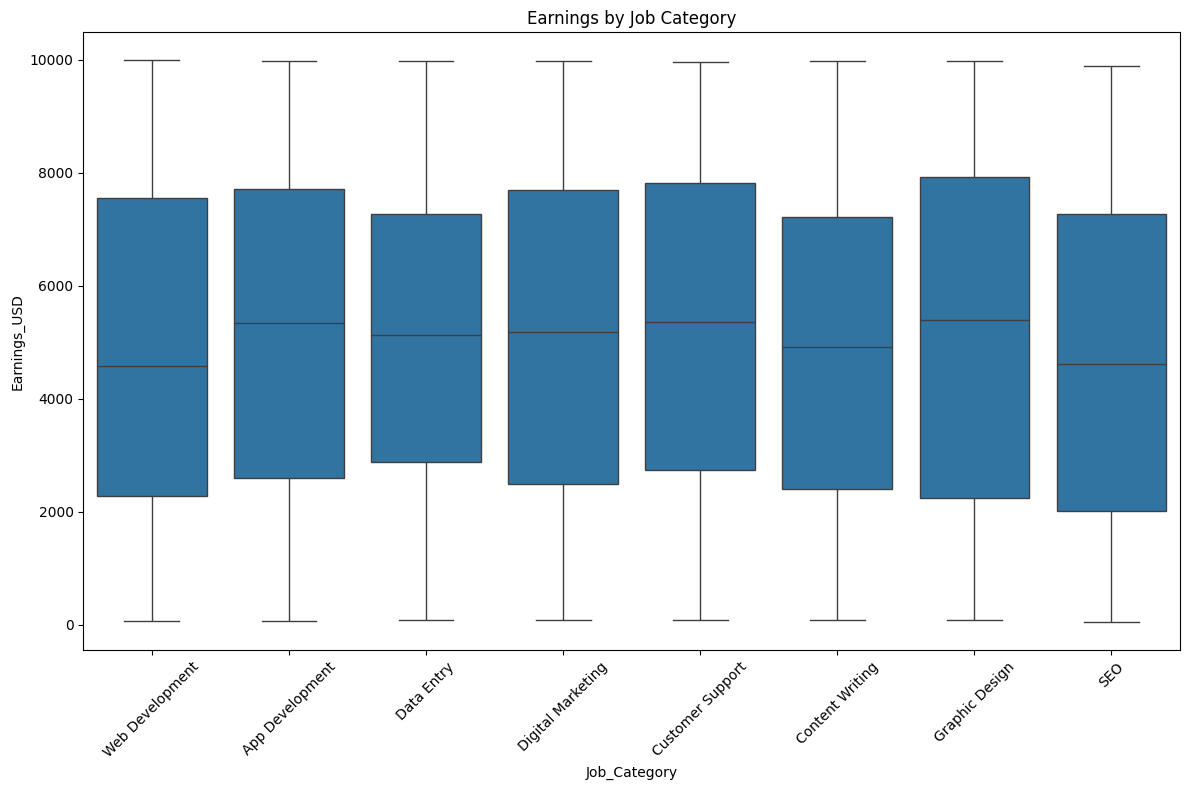

In [72]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Job_Category', y='Earnings_USD', data=df)
plt.title('Earnings by Job Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/Users/samanvitha/mlops/notebooks/images/earnings_by_category.png')

In [73]:
with mlflow.start_run(run_name="Data_Exploration"):
    # Log the dataset metrics
    mlflow.log_param("dataset_size", df.shape[0])
    mlflow.log_param("num_features", df.shape[1])
    
    # Log some basic stats
    mlflow.log_metric("avg_earnings", df['Earnings_USD'].mean())
    mlflow.log_metric("avg_hourly_rate", df['Hourly_Rate'].mean())
    mlflow.log_metric("avg_success_rate", df['Job_Success_Rate'].mean())
    
    # Log the correlation matrix as an artifact
    mlflow.log_artifact('/Users/samanvitha/mlops/notebooks/images/correlation_matrix_num.png')
    mlflow.log_artifact('/Users/samanvitha/mlops/notebooks/images/distributions.png')
    mlflow.log_artifact('/Users/samanvitha/mlops/notebooks/images/earnings_vs_rate.png')
    mlflow.log_artifact('/Users/samanvitha/mlops/notebooks/images/earnings_by_category.png')
    mlflow.log_artifact('/Users/samanvitha/mlops/notebooks/images/correlation_matrix_num.png')
    mlflow.log_artifact('/Users/samanvitha/mlops/notebooks/images/categorical_boxplots.png')

In [74]:
target = 'Earnings_USD'

In [75]:
def add_engineered_features(df):
    df_new = df.copy()
    df_new['Success_Rating_Ratio'] = df_new['Job_Success_Rate'] / df_new['Client_Rating']
    df_new['Earnings_Per_Job'] = df_new['Earnings_USD'] / df_new['Job_Completed']
    df_new['Marketing_Per_Job'] = df_new['Marketing_Spend'] / df_new['Job_Completed']
    df_new['Hourly_Success_Interaction'] = df_new['Hourly_Rate'] * df_new['Job_Success_Rate'] / 100
    return df_new

In [76]:
numeric_features = ['Job_Completed', 'Hourly_Rate', 'Job_Success_Rate', 
                    'Client_Rating', 'Job_Duration_Days', 'Rehire_Rate', 'Marketing_Spend']
categorical_features = ['Job_Category', 'Platform', 'Experience_Level', 
                         'Client_Region', 'Payment_Method', 'Project_Type']

In [77]:
df_engineered = add_engineered_features(df)

new_numeric_features = ['Success_Rating_Ratio', 'Earnings_Per_Job', 
                        'Marketing_Per_Job', 'Hourly_Success_Interaction']
numeric_features.extend(new_numeric_features)

if target in numeric_features:
    numeric_features.remove(target)

X = df_engineered.drop(columns=[target, 'Freelancer_ID', 'Earnings_Per_Job'])
y = df_engineered[target]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 1365 samples
Validation set: 292 samples
Test set: 293 samples


In [78]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

print("Actual columns in the dataframe:")
print(X_train.columns.tolist())

# Now let's redefine the preprocessing pipeline to ensure we only use existing columns
# Make sure numeric_features and categorical_features only include columns that exist

# Verify numeric features exist
valid_numeric_features = [col for col in numeric_features if col in X_train.columns]
print(f"Valid numeric features: {valid_numeric_features}")

# Verify categorical features exist
valid_categorical_features = [col for col in categorical_features if col in X_train.columns]
print(f"Valid categorical features: {valid_categorical_features}")

# Recreate the preprocessing pipeline with verified columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, valid_numeric_features),
        ('cat', categorical_transformer, valid_categorical_features)
    ])


Actual columns in the dataframe:
['Job_Category', 'Platform', 'Experience_Level', 'Client_Region', 'Payment_Method', 'Job_Completed', 'Hourly_Rate', 'Job_Success_Rate', 'Client_Rating', 'Job_Duration_Days', 'Project_Type', 'Rehire_Rate', 'Marketing_Spend', 'Success_Rating_Ratio', 'Marketing_Per_Job', 'Hourly_Success_Interaction']
Valid numeric features: ['Job_Completed', 'Hourly_Rate', 'Job_Success_Rate', 'Client_Rating', 'Job_Duration_Days', 'Rehire_Rate', 'Marketing_Spend', 'Success_Rating_Ratio', 'Marketing_Per_Job', 'Hourly_Success_Interaction']
Valid categorical features: ['Job_Category', 'Platform', 'Experience_Level', 'Client_Region', 'Payment_Method', 'Project_Type']


In [79]:
with mlflow.start_run(run_name="Data_Preprocessing"):
    # Log the dataset versions
    mlflow.log_param("train_size", X_train.shape[0])
    mlflow.log_param("validation_size", X_val.shape[0])
    mlflow.log_param("test_size", X_test.shape[0])
    mlflow.log_param("num_features_after_engineering", X_train.shape[1])
    
    # We can also log the actual datasets as artifacts
    X_train.to_csv("save_data/X_train.csv", index=False)
    y_train.to_csv("save_data/y_train.csv", index=False)
    X_val.to_csv("save_data/X_val.csv", index=False)
    y_val.to_csv("save_data/y_val.csv", index=False)
    X_test.to_csv("save_data/X_test.csv", index=False)
    y_test.to_csv("save_data/y_test.csv", index=False)
    
    mlflow.log_artifact("save_data/X_train.csv", artifact_path='save_data')
    mlflow.log_artifact("save_data/y_train.csv", artifact_path='save_data')
    mlflow.log_artifact("save_data/y_train.csv", artifact_path='save_data')
    mlflow.log_artifact("save_data/X_val.csv", artifact_path='save_data')
    mlflow.log_artifact("save_data/y_val.csv", artifact_path='save_data')
    mlflow.log_artifact("save_data/X_test.csv", artifact_path='save_data')
    mlflow.log_artifact("save_data/y_test.csv", artifact_path='save_data')

2025/03/22 19:09:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/22 19:11:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/22 19:12:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


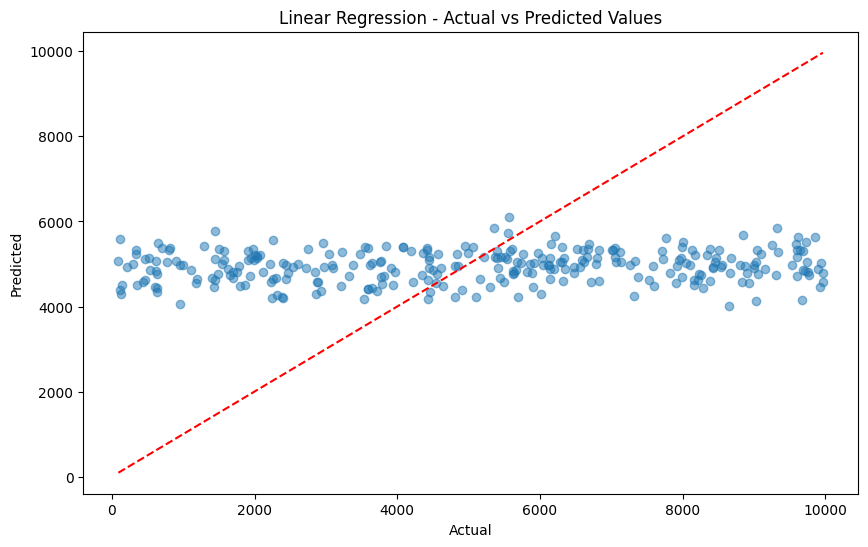

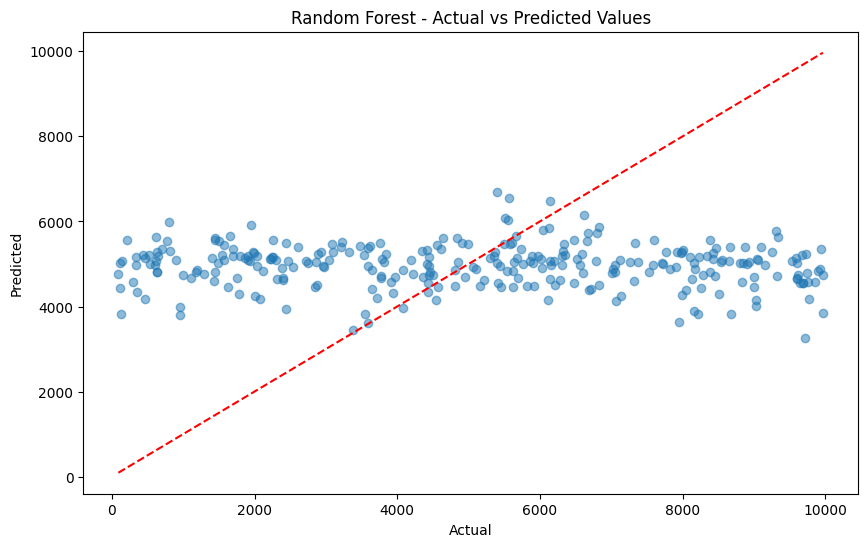

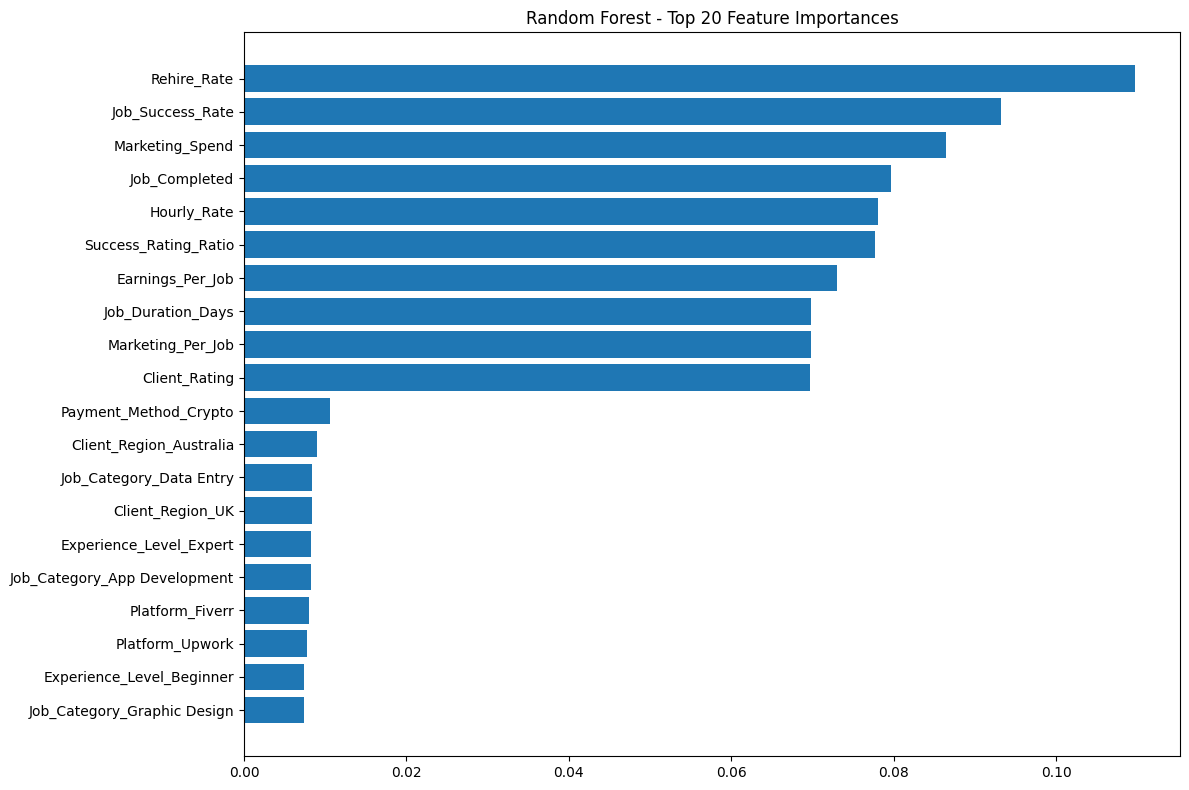

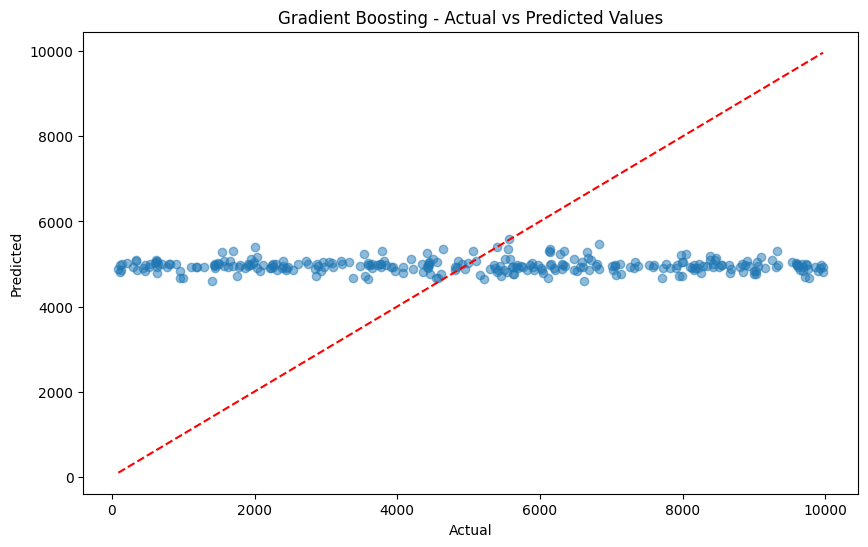

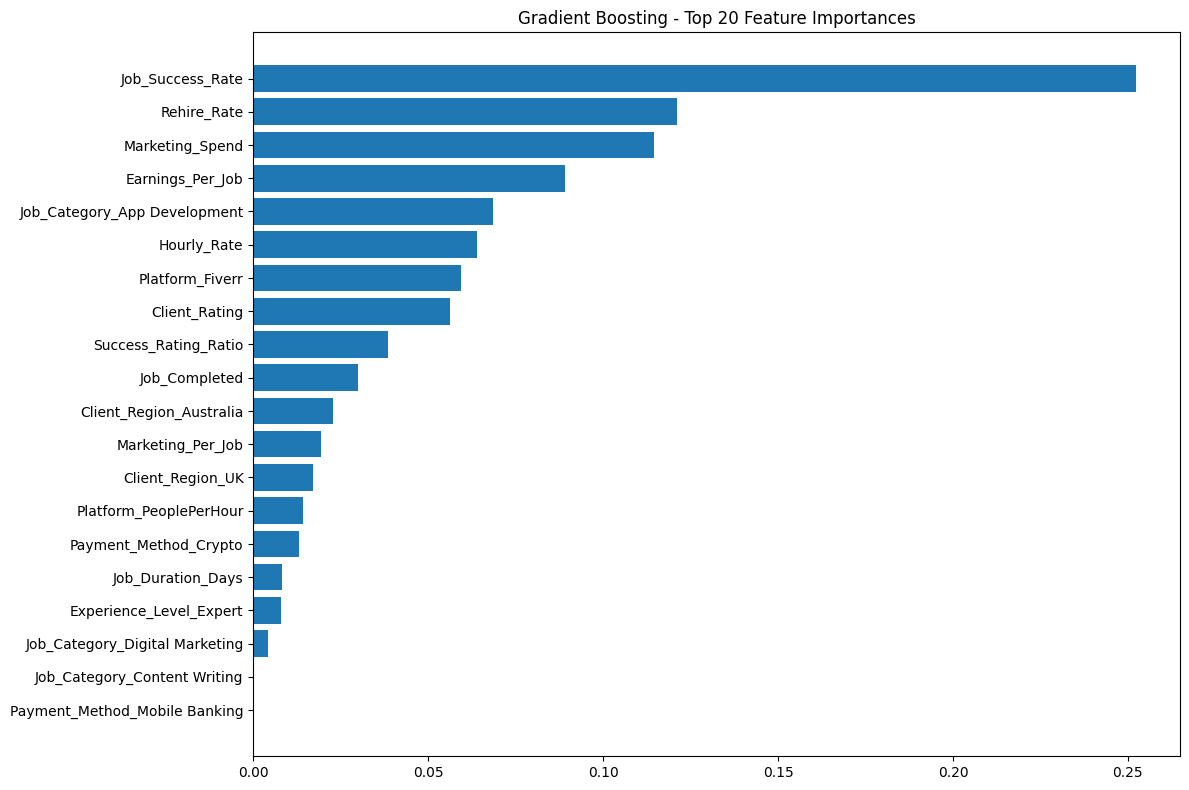

In [80]:
# Define a function to train and evaluate a model
def train_and_evaluate_model(model, model_name, X_train, y_train, X_val, y_val, params=None):
    with mlflow.start_run(run_name=f"{model_name}_Training"):
        # Create the full pipeline with preprocessing
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Log parameters
        if params:
            for param_name, param_value in params.items():
                mlflow.log_param(param_name, param_value)
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Make predictions on validation set
        y_val_pred = pipeline.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae = mean_absolute_error(y_val, y_val_pred)
        r2 = r2_score(y_val, y_val_pred)
        
        # Log metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        
        # Log the model
        mlflow.sklearn.log_model(pipeline, f"{model_name}_model")
        
        # Create a scatter plot of predicted vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_val, y_val_pred, alpha=0.5)
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'{model_name} - Actual vs Predicted Values')
        plt.savefig(f'{model_name}_predictions.png')
        mlflow.log_artifact(f'{model_name}_predictions.png')
        
        return {
            'model': pipeline,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }

# 1. Linear Regression with hyperparameter tuning
lr_params = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]  # Instead of normalize, which is deprecated
}

lr_grid = GridSearchCV(
    Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]),
    param_grid=lr_params,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

with mlflow.start_run(run_name="LinearRegression_Tuning"):
    lr_grid.fit(X_train, y_train)
    
    # Log best parameters
    mlflow.log_params(lr_grid.best_params_)
    
    # Log best score
    mlflow.log_metric("best_neg_rmse", lr_grid.best_score_)
    
    # Make predictions on validation set
    y_val_pred = lr_grid.predict(X_val)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # Log the model
    mlflow.sklearn.log_model(lr_grid, "linear_regression_model")
    
    # Create a scatter plot of predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_val_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Linear Regression - Actual vs Predicted Values')
    plt.savefig('lr_predictions.png')
    mlflow.log_artifact('lr_predictions.png')
    
    lr_results = {
        'model': lr_grid,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# 2. Random Forest with hyperparameter tuning
rf_params = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(
    Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    param_grid=rf_params,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

with mlflow.start_run(run_name="RandomForest_Tuning"):
    rf_grid.fit(X_train, y_train)
    
    # Log best parameters
    mlflow.log_params(rf_grid.best_params_)
    
    # Log best score
    mlflow.log_metric("best_neg_rmse", rf_grid.best_score_)
    
    # Make predictions on validation set
    y_val_pred = rf_grid.predict(X_val)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # Log the model
    mlflow.sklearn.log_model(rf_grid, "random_forest_model")
    
    # Create a scatter plot of predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_val_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Random Forest - Actual vs Predicted Values')
    plt.savefig('rf_predictions.png')
    mlflow.log_artifact('rf_predictions.png')
    
    # Feature importance plot
    feature_names = numeric_features + list(rf_grid.best_estimator_.named_steps['preprocessor']
                                         .named_transformers_['cat']
                                         .named_steps['onehot']
                                         .get_feature_names_out(categorical_features))
    
    feature_importances = rf_grid.best_estimator_.named_steps['model'].feature_importances_
    
    plt.figure(figsize=(12, 8))
    indices = np.argsort(feature_importances)[-20:]  # Top 20 features
    plt.barh(range(len(indices)), feature_importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title('Random Forest - Top 20 Feature Importances')
    plt.tight_layout()
    plt.savefig('rf_feature_importance.png')
    mlflow.log_artifact('rf_feature_importance.png')
    
    rf_results = {
        'model': rf_grid,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# 3. Gradient Boosting with hyperparameter tuning
gb_params = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}

gb_grid = GridSearchCV(
    Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    param_grid=gb_params,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

with mlflow.start_run(run_name="GradientBoosting_Tuning"):
    gb_grid.fit(X_train, y_train)
    
    # Log best parameters
    mlflow.log_params(gb_grid.best_params_)
    
    # Log best score
    mlflow.log_metric("best_neg_rmse", gb_grid.best_score_)
    
    # Make predictions on validation set
    y_val_pred = gb_grid.predict(X_val)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # Log the model
    mlflow.sklearn.log_model(gb_grid, "gradient_boosting_model")
    
    # Create a scatter plot of predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_val_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Gradient Boosting - Actual vs Predicted Values')
    plt.savefig('gb_predictions.png')
    mlflow.log_artifact('gb_predictions.png')
    
    # Feature importance plot
    feature_names = numeric_features + list(gb_grid.best_estimator_.named_steps['preprocessor']
                                         .named_transformers_['cat']
                                         .named_steps['onehot']
                                         .get_feature_names_out(categorical_features))
    
    feature_importances = gb_grid.best_estimator_.named_steps['model'].feature_importances_
    
    plt.figure(figsize=(12, 8))
    indices = np.argsort(feature_importances)[-20:]  # Top 20 features
    plt.barh(range(len(indices)), feature_importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title('Gradient Boosting - Top 20 Feature Importances')
    plt.tight_layout()
    plt.savefig('gb_feature_importance.png')
    mlflow.log_artifact('gb_feature_importance.png')
    
    gb_results = {
        'model': gb_grid,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

In [81]:
# Feature selection using SelectKBest
with mlflow.start_run(run_name="Feature_Selection"):
    # Apply the preprocessor to get a clean dataset for feature selection
    X_train_processed = preprocessor.fit_transform(X_train)
    
    # Get feature names after preprocessing
    feature_names = (
        numeric_features + 
        list(preprocessor.named_transformers_['cat']
             .named_steps['onehot']
             .get_feature_names_out(categorical_features))
    )
    
    # Create a feature selector
    selector = SelectKBest(f_regression, k=10)  # Select top 10 features
    X_train_selected = selector.fit_transform(X_train_processed, y_train)
    
    # Get indices of selected features
    selected_indices = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_indices]
    
    # Log the selected features
    mlflow.log_param("num_selected_features", len(selected_features))
    mlflow.log_param("selected_features", selected_features)
    
    # Create a new preprocessor that includes feature selection
    preprocessor_with_selection = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', selector)
    ])
    
    # Log information about the reduced feature set
    mlflow.log_metric("original_features", X_train_processed.shape[1])
    mlflow.log_metric("selected_features", X_train_selected.shape[1])

# Now retrain the models with feature selection
# 1. Linear Regression with selected features
# Linear Regression with selected features - corrected parameters
lr_fs_params = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]  # Instead of normalize
}

lr_fs_grid = GridSearchCV(
    Pipeline(steps=[
        ('preprocessor_with_selection', preprocessor_with_selection),
        ('model', LinearRegression())
    ]),
    param_grid=lr_fs_params,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

with mlflow.start_run(run_name="LinearRegression_FeatureSelection"):
    lr_fs_grid.fit(X_train, y_train)
    
    # Log best parameters
    mlflow.log_params(lr_fs_grid.best_params_)
    
    # Make predictions on validation set
    y_val_pred = lr_fs_grid.predict(X_val)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # Log the model
    mlflow.sklearn.log_model(lr_fs_grid, "linear_regression_fs_model")
    
    lr_fs_results = {
        'model': lr_fs_grid,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# 2. Random Forest with selected features
rf_fs_params = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20]
}

rf_fs_grid = GridSearchCV(
    Pipeline(steps=[
        ('preprocessor_with_selection', preprocessor_with_selection),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    param_grid=rf_fs_params,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

with mlflow.start_run(run_name="RandomForest_FeatureSelection"):
    rf_fs_grid.fit(X_train, y_train)
    
    # Log best parameters
    mlflow.log_params(rf_fs_grid.best_params_)
    
    # Make predictions on validation set
    y_val_pred = rf_fs_grid.predict(X_val)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # Log the model
    mlflow.sklearn.log_model(rf_fs_grid, "random_forest_fs_model")
    
    rf_fs_results = {
        'model': rf_fs_grid,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# 3. Gradient Boosting with selected features
gb_fs_params = {
    'model__n_estimators': [50, 100],
    'model__learning_rate': [0.1, 0.2],
    'model__max_depth': [3, 5]
}

gb_fs_grid = GridSearchCV(
    Pipeline(steps=[
        ('preprocessor_with_selection', preprocessor_with_selection),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    param_grid=gb_fs_params,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

with mlflow.start_run(run_name="GradientBoosting_FeatureSelection"):
    gb_fs_grid.fit(X_train, y_train)
    
    # Log best parameters
    mlflow.log_params(gb_fs_grid.best_params_)
    
    # Make predictions on validation set
    y_val_pred = gb_fs_grid.predict(X_val)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # Log the model
    mlflow.sklearn.log_model(gb_fs_grid, "gradient_boosting_fs_model")
    
    gb_fs_results = {
        'model': gb_fs_grid,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

2025/03/22 19:12:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/22 19:13:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/03/22 19:13:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



Model Performance Summary (sorted by validation RMSE):
--------------------------------------------------------------------------------
Model                                    RMSE       MAE        R²        
--------------------------------------------------------------------------------
Linear Regression                        2872.2808  2457.3281  0.0133    
Gradient Boosting                        2901.1496  2496.9644  -0.0066   
Linear Regression (Feature Selection)    2918.5578  2500.5070  -0.0187   
Gradient Boosting (Feature Selection)    2961.8626  2540.6401  -0.0492   
Random Forest                            2971.6231  2518.7494  -0.0561   
Random Forest (Feature Selection)        2982.0205  2548.0414  -0.0635   

Top 3 Models:
1. Linear Regression
2. Gradient Boosting
3. Linear Regression (Feature Selection)

Best Model: Linear Regression


2025/03/22 19:13:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



Test Set Metrics for Linear Regression:
RMSE: 2976.4477
MAE: 2585.5979
R²: -0.0466


Successfully registered model 'FreelancerEarningsPrediction'.
Created version '1' of model 'FreelancerEarningsPrediction'.
/var/folders/1q/461kwq6d42j7t8d6yytb5nyw0000gp/T/ipykernel_31057/3224570051.py:57: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


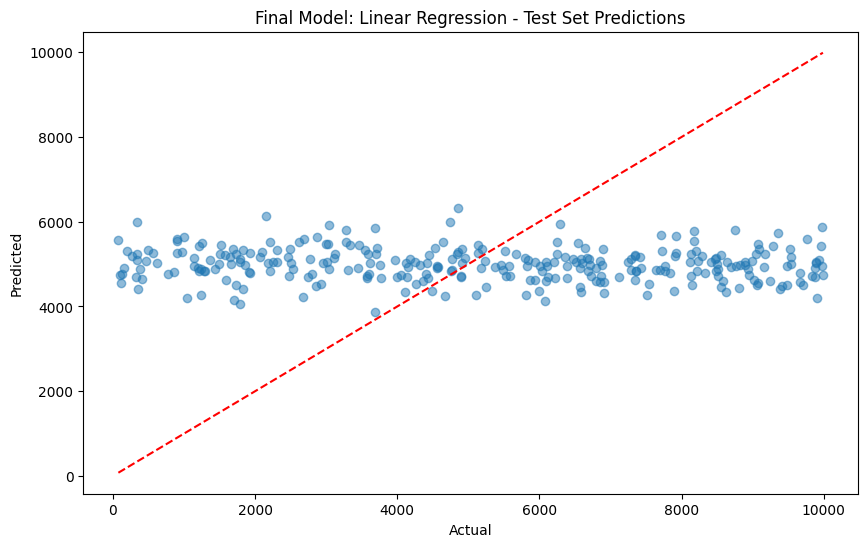

In [82]:
# Collect all model results
all_models = {
    "Linear Regression": lr_results,
    "Random Forest": rf_results,
    "Gradient Boosting": gb_results,
    "Linear Regression (Feature Selection)": lr_fs_results,
    "Random Forest (Feature Selection)": rf_fs_results,
    "Gradient Boosting (Feature Selection)": gb_fs_results
}

# Sort models by validation RMSE (lower is better)
sorted_models = sorted(all_models.items(), key=lambda x: x[1]['rmse'])

# Print model performance summary
print("\nModel Performance Summary (sorted by validation RMSE):")
print("-" * 80)
print(f"{'Model':<40} {'RMSE':<10} {'MAE':<10} {'R²':<10}")
print("-" * 80)
for model_name, results in sorted_models:
    print(f"{model_name:<40} {results['rmse']:<10.4f} {results['mae']:<10.4f} {results['r2']:<10.4f}")

# Get the top 3 models
top3_models = sorted_models[:3]
print("\nTop 3 Models:")
for rank, (model_name, _) in enumerate(top3_models, 1):
    print(f"{rank}. {model_name}")

# Select the best model
best_model_name, best_model_results = top3_models[0]
best_model = best_model_results['model']

print(f"\nBest Model: {best_model_name}")

# Log the dataset versions for the top 3 models
with mlflow.start_run(run_name="Top_Models_Datasets"):
    # Log the exact datasets used for training and validation
    for rank, (model_name, _) in enumerate(top3_models, 1):
        X_train.to_csv(f"X_train_top{rank}.csv", index=False)
        y_train.to_csv(f"y_train_top{rank}.csv", index=False)
        X_val.to_csv(f"X_val_top{rank}.csv", index=False)
        y_val.to_csv(f"y_val_top{rank}.csv", index=False)
        
        mlflow.log_artifact(f"X_train_top{rank}.csv")
        mlflow.log_artifact(f"y_train_top{rank}.csv")
        mlflow.log_artifact(f"X_val_top{rank}.csv")
        mlflow.log_artifact(f"y_val_top{rank}.csv")

# Evaluate the best model on the test set
with mlflow.start_run(run_name="Final_Model_Evaluation"):
    # Register the best model
    mlflow.sklearn.log_model(best_model, f"final_{best_model_name}_model")
    
    # Create a production stage for this model
    client = mlflow.tracking.MlflowClient()
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/final_{best_model_name}_model"
    model_details = mlflow.register_model(model_uri, "FreelancerEarningsPrediction")
    client.transition_model_version_stage(
        name="FreelancerEarningsPrediction",
        version=model_details.version,
        stage="Production"
    )
    
    # Make predictions on test set
    y_test_pred = best_model.predict(X_test)
    
    # Calculate metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Log metrics
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_r2", test_r2)
    
    print(f"\nTest Set Metrics for {best_model_name}:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"R²: {test_r2:.4f}")
    
    # Create a scatter plot of predicted vs actual values on test set
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Final Model: {best_model_name} - Test Set Predictions')
    plt.savefig('final_model_test_predictions.png')
    mlflow.log_artifact('final_model_test_predictions.png')
    
    # Log the test dataset
    X_test.to_csv("X_test_final.csv", index=False)
    y_test.to_csv("y_test_final.csv", index=False)
    mlflow.log_artifact("X_test_final.csv")
    mlflow.log_artifact("y_test_final.csv")